# **Pipeline III**

After comparing my and Ibb's music tastes, I wanted to "delve" into generative NLP, mainly experimenting with transformer architectures and various techniques to make them more efficient, which have been becoming more critical since computing is a significant constraint across the industry. I tried Disagreement Regularization, Grouped Query Attention, and Mixture of Depths Routing, the last two of which came out 4 months ago and 3 weeks ago, respectively. Finding that the first technique does not work, I spliced together the last two techniques to create a **novel hybrid GQA-MoD architecutre**, surpassing both of the original architectures in terms of speed while performing similarly to them on perplexity, generally superior to a "vanilla" implementation. It is worth mentioning that I found that this speed boost was consistent when I used CPU; it became negligible on GPU, showing that hardware has a strong impact since there might be underlying optimizations being performed on the model's running, and a "vanilla" Transformer model might be the target of such optimizations.

I then trained a songwriter language model on it; however, I faced issues training larger models, such as gradient explosions. However, I was able to train a small model and, more importantly, propose a new hybrid architecture, at least on a tiny 4M parameter scale.

## **Load Data**

Since training would require a lot of data and Spotify is only so generous with their API, I decided to use an external song lyrics dataset from [Kaggle]((https://www.kaggle.com/datasets/terminate9298/songs-lyrics?select=lyrics.csv) ) that includes lyrics from over 25,000 songs, mostly in English, by 500 unique artists. The dataset contains a total of 7,619,966 unique words, providing sufficient data to train a small language model. I added artist names to the dataset hoping this would help the model learn specific artistic styles, thereby enhancing its ability to generate artist-specific lyrics upon inference. I employed byte-pair encoding to tokenize the dataset, which groups together frequently co-occurring characters. The total number of unique words in my dataset was just under 5,000.

In [ ]:
pip install bpemb

In [ ]:
from bs4 import BeautifulSoup
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import prune
import math
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from datetime import datetime
from torch.utils.data import Dataset
from collections import Counter
from typing import List
from transformers import AutoTokenizer
import pandas as pd
import re
from bpemb import BPEmb

In [ ]:
# Load data from CSV, ignoring malformed lines
df = pd.read_csv("/content/lyrics.csv", on_bad_lines='skip')

# Remove the 'link' column as it's not needed
df = df.drop(columns=['link'])

# Calculate number of words in 'lyrics' assuming space as delimiter
df['token_count'] = df['lyrics'].apply(lambda x: len(x.split()))
print("Total number of tokens:", df['token_count'].sum())

# Clean the lyrics text using a predefined function
df['artist'] = df['artist'].str.replace(' Lyrics', '')
df['formatted'] = df.apply(lambda row: row['artist'] + (" " + row['lyrics'] if row['lyrics'] else ""), axis=1)
df['formatted_token_count'] = df['formatted'].apply(lambda x: len(x.split()))
max_formatted_tokens = df['formatted_token_count'].max()
print("Maximum number of tokens in 'formatted':", max_formatted_tokens)

# Determine and print the number of unique artists
unique_artists = df['artist'].nunique()
print("Number of unique artists:", unique_artists)

# Convert the 'formatted' column to lowercase
df['formatted'] = df['formatted'].str.lower()

# Remove unneeded columns to tidy up the DataFrame
df = df.drop(columns=['artist', 'token_count', 'lyrics', 'song_name', 'Unnamed: 0'])

Total number of tokens: 7619966
Maximum number of tokens in 'formatted': 3708
Number of unique artists: 542


In [ ]:
class BPETokenizer:
    """
    Tokenizer based on Byte-Pair Encoding (BPE) to manage vocabulary and encoding/decoding of text.
    """
    def __init__(self, lang="en", vs=20000):
        """
        Initialize the BPE tokenizer with specified language and vocabulary size, adding special tokens.
        """
        self.bpemb = BPEmb(lang=lang, vs=vs)
        self.vocab_size = self.bpemb.vocab_size + 2  # Account for PAD and UNK tokens

        # Mapping from words to indices, offset by 2 to accommodate special tokens
        self.word_index = {word: idx + 2 for idx, word in enumerate(self.bpemb.words)}
        self.word_index["<PAD>"] = 0
        self.word_index["<UNK>"] = 1

        # Reverse mapping from indices to words
        self.index_word = {idx: word for word, idx in self.word_index.items()}

    def encode(self, text):
        """
        Convert text to a list of indices. Unknown words are mapped to <UNK>.
        """
        return [self.word_index.get(word, 1) for word in self.bpemb.encode(text)]

    def decode(self, indices):
        """
        Convert a list of indices back to text, skipping special tokens.
        """
        return ''.join(self.index_word.get(idx, "<UNK>") for idx in indices if idx > 1)

    def get_vocab_size(self):
        """
        Return the total vocabulary size, including special tokens.
        """
        return self.vocab_size


class TransformersTextDataset(Dataset):
    """
    Dataset class for text data prepared for training transformer models, handling tokenization and segmentation.
    """
    def __init__(self, texts, seq_length, lang="en", vs=20000):
        """
        Initialize dataset with texts, sequence length, and tokenizer parameters.
        """
        self.tokenizer = BPETokenizer(lang=lang, vs=vs)
        self.seq_length = seq_length
        self.tokenized_segments = self.tokenize_and_segment_texts(texts)

    def tokenize_and_segment_texts(self, texts):
        """
        Tokenize input texts and split into fixed-size segments, padding as needed.
        """
        tokenized_segments = []
        pad_id = self.tokenizer.word_index["<PAD>"]
        for text in texts:
            encoded = self.tokenizer.encode(text)
            padded_length = (len(encoded) + self.seq_length - 1) // self.seq_length * self.seq_length
            encoded.extend([pad_id] * (padded_length - len(encoded)))

            chunks = [encoded[i:i + self.seq_length] for i in range(0, len(encoded), self.seq_length)]
            tokenized_segments.extend(chunks)
        return tokenized_segments

    def unique_words(self):
        """
        Calculate the number of unique words in the tokenized segments, excluding special tokens.
        """
        return len(set(word for segment in self.tokenized_segments for word in segment if word > 1))

    def __len__(self):
        """
        Return the number of segments in the dataset.
        """
        return len(self.tokenized_segments)

    def __getitem__(self, idx):
        """
        Retrieve a pair of input-target sequences from the dataset by index.
        """
        segment = self.tokenized_segments[idx]
        return torch.tensor(segment[:-1], dtype=torch.long), torch.tensor(segment[1:], dtype=torch.long)

In [ ]:
# Assume 'df' is your DataFrame and 'formatted' is the column with text data
texts = df['formatted'].tolist()

# Initialize dataset with first 1000 formatted texts, a sequence length of 64, and a vocab size of 5000
dataset = TransformersTextDataset(texts, seq_length=64, vs=5000)
print(f'Number of unique words in dataset: {dataset.unique_words()}')
print(f'Vocabulary size of tokenizer: {dataset.tokenizer.get_vocab_size()}')

# Calculate train/test split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Randomly split dataset into training and testing parts
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Output sizes of the splits
print(f'Training dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

# Create DataLoaders for batch processing of training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs5000.model


100%|██████████| 315918/315918 [00:00<00:00, 1064684.37B/s]


downloading https://nlp.h-its.org/bpemb/en/en.wiki.bpe.vs5000.d100.w2v.bin.tar.gz


100%|██████████| 1888515/1888515 [00:00<00:00, 3160270.40B/s]


Number of unique words in dataset: 4859
Vocabulary size of tokenizer: 5002
Training dataset size: 180431
Test dataset size: 45108


In [ ]:
# Use GPU if available (I used L4 from Google Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## **Metrics**

Cross entropy is a measure used to quantify the difference between two probability distributions—the predicted probabilities from the model and the actual distribution as represented by the true data labels.


In PyTorch, `torch.nn.CrossEntropyLoss` is commonly, it simplifies the process by directly accepting the raw logits from the neural network's output and the labels as class indices.


The cross entropy loss is defined as:

$$
H(p, q) = -\sum_{x} p(x) \log q(x)
$$

- $p(x)$ represents the true probability distribution, where the correct class has a probability of 1 and all others have 0.
- $q(x)$ is the predicted probability distribution over the classes, output from the model and passed through a softmax function.
- The summation is over all classes in the vocabulary.

However, when using `torch.nn.CrossEntropyLoss`, the formula simplifies and is internally computed as:

$$
H(p, q) = -\log \left(\frac{e^{s_{y_i}}}{\sum_j e^{s_j}}\right)
$$

Here:
- $s_{y_i}$ is the logit corresponding to the true class  $y_i$.
- $s_j$ are the logits for all classes.

**Perplexity as a Metric**

Perplexity is a performance metric for language models, indicating how well a probability model predicts a sample. It calculates as the exponential of the average negative log-likelihood of predicting a sequence of words. A lower perplexity score suggests a model that predicts with higher certainty. We will use it to compare the performance of different models.

The perplexity of a language model given a text is:

$$
P(W) = \exp\left(-\frac{1}{N} \sum_{i=1}^N \log q(x_i)\right)
$$

- $W$ denotes the sequence of words.
- $N$ is the total number of words in $W$.
- $q(x_i)$ is the probability assigned by the model to the actual word $x_i$ at position $i$.

A lower perplexity indicates that the model is more certain about its predictions, making fewer errors. By reducing the cross entropy loss during training, we decrease perplexity, which in turn enhances the model's ability to accurately predict text and produce more coherent outputs.

## **Vanilla Transformer**

A "vanilla" standard decoder-only transformer architecture is used as a baseline for comparison for all other models.

In [ ]:
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime

In [ ]:
class TransformerDecoderLayerVanilla(nn.Module):
    # Defines a single layer of a transformer decoder as used in the original "Attention is All You Need" paper.
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        # Multihead attention for the target sequence
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # First feedforward layer
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        # Dropout added to the output of the feedforward layers
        self.dropout = nn.Dropout(dropout)
        # Second feedforward layer that projects back to d_model
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        # Layer normalization (first and second)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout for output of the self-attention and feedforward network
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None, **kwargs):
        # Self-attention on the target sequence
        tgt2 = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask,
                              key_padding_mask=tgt_key_padding_mask)[0]
        # Apply dropout and add to original target sequence for residual connection
        tgt = tgt + self.dropout1(tgt2)
        # Apply layer normalization
        tgt = self.norm1(tgt)
        # Pass through the feedforward network
        tgt2 = self.linear2(self.dropout(nn.functional.relu(self.linear1(tgt))))
        # Second residual connection
        tgt = tgt + self.dropout2(tgt2)
        # Second layer normalization
        tgt = self.norm2(tgt)
        return tgt

class TransformerWithVanillaDecoder(nn.Module):
    # Defines a transformer model with a stack of TransformerDecoderLayerVanilla layers
    def __init__(self, target_vocab_size, d_model, nhead, num_decoder_layers, dim_feedforward=2048, max_seq_length=512, dropout=0.1):
        super().__init__()
        # Embedding layer for target vocab
        self.embedding = nn.Embedding(target_vocab_size, d_model)
        # Initialize the Vanilla Transformer decoder layer
        decoder_layer = TransformerDecoderLayerVanilla(d_model, nhead, dim_feedforward, dropout)
        # Stack of decoder layers
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)
        # Output linear layer to map decoder output to target vocabulary size
        self.output_layer = nn.Linear(d_model, target_vocab_size)
        # Positional encodings for input sequences
        self.pos_encoder = self.create_positional_encoding(max_seq_length, d_model)
        self.d_model = d_model

    # Generate a mask for the sequence to prevent attention to subsequent positions
    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    # Create Sinosidal Positional Encoding
    def create_positional_encoding(self, length, d_model):
        position = torch.arange(length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pos_encoder = torch.zeros(length, d_model)
        pos_encoder[:, 0::2] = torch.sin(position * div_term)
        pos_encoder[:, 1::2] = torch.cos(position * div_term)
        return nn.Parameter(pos_encoder, requires_grad=False)

    # Define the forward pass
    def forward(self, tgt):
        tgt_seq_length = tgt.size(0)
        batch_size = tgt.size(1)

        tgt_mask = self.generate_square_subsequent_mask(tgt_seq_length).to(tgt.device)

        tgt = self.embedding(tgt) * math.sqrt(self.d_model)
        pos_encoder = self.pos_encoder[:tgt_seq_length, :].unsqueeze(1).expand(-1, batch_size, -1).to(tgt.device)

        tgt = tgt + pos_encoder
        memory = tgt.clone()
        output = self.transformer_decoder(tgt, memory, tgt_mask=tgt_mask)
        output = self.output_layer(output)
        return output

In [ ]:
# Setting hyperparameters for the model
vocab_size = 5002  # Total number of words (including special tokens) in the vocabulary
d_model = 64  # Dimensionality of the embedding layer and all transformer layers
nhead = 8  # Number of attention heads in each attention layer of the transformer
num_decoder_layers = 4  # Total number of stacked decoder layers in the transformer
dim_feedforward = 512  # Dimensionality of the feedforward network model in transformer
max_seq_length = 64  # Maximum length of input sequences
dropout = 0.1  # Dropout rate applied in attention and feedforward networks

# Create an instance of the Transformer model configured with the specified parameters
model = TransformerWithVanillaDecoder(
    target_vocab_size=vocab_size,
    d_model=d_model,
    nhead=nhead,
    num_decoder_layers=num_decoder_layers,
    dim_feedforward=dim_feedforward,
    max_seq_length=max_seq_length,
    dropout=dropout
).to(device)  # Ensure the model is on the correct device (GPU or CPU)

# Define the loss function for training with CrossEntropy, which is typical for classification tasks
loss_fn = nn.CrossEntropyLoss().to(device)  # Move loss function to the same device as model

# Set up the optimizer that will update the weights of the model during training
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer with learning rate of 0.001

# Number of training epochs - the complete passes over the dataset
epochs = 3

# Training loop
for epoch in range(epochs):
    start_time = datetime.now()  # Record the start time for the epoch
    model.train()  # Set the model to training mode which enables dropout layers and batch normalization
    total_loss = 0  # Initialize total loss for the epoch

    # Iterate over batches of data from the training loader
    for batch in train_loader:
        inputs, targets = batch

        # Ensure data tensors are on the correct device
        inputs = inputs.long().to(device)
        targets = targets.long().to(device)

        # Reset gradients from the previous iteration
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(inputs)
        # Reshape the model output and targets to fit the loss function requirements
        output = output.reshape(-1, vocab_size)  # Flatten output for cross-entropy which expects 2D inputs
        targets = targets.reshape(-1)

        # Compute loss between the model output and true targets
        loss = loss_fn(output, targets)
        loss.backward()  # Perform backpropagation to compute gradients
        optimizer.step()  # Update model weights

        total_loss += loss.item()  # Aggregate the loss over the epoch

    # Calculate the duration of training in seconds
    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()

    # Log training details
    print(f"Epoch {epoch}, Total Loss: {total_loss}, Training Time: {training_time} seconds")

Epoch 0, Total Loss: 903.3834438323975, Training Time: 26.458033 seconds
Epoch 1, Total Loss: 704.1775319576263, Training Time: 25.798196 seconds
Epoch 2, Total Loss: 649.334231376648, Training Time: 25.501088 seconds


In [ ]:
model1 = model

In [ ]:
# Approximate model size by counting parameters
model.eval()
model_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has approximately {model_parameters} trainable parameters.')

The model has approximately 977290 trainable parameters.


In [ ]:
import torch
import torch.nn.functional as F

def generate_text(model, start_sequence, max_length=50, temperature=1.2, top_p=0.9):
    """
    Generates text from a starting sequence using the transformer model with top-p sampling.
    """
    model.eval()  # Switch model to evaluation mode (disables dropout)
    sequence = start_sequence  # Initialize sequence with the start_sequence provided

    # Disable gradient calculations for efficiency and safety (model weights won't be updated)
    with torch.no_grad():
        for _ in range(max_length):  # Generate up to max_length tokens
            output = model(sequence)  # Forward pass through the model
            logits = output[:, -1, :] / temperature  # Scale logits by temperature to smooth the distribution

            # Sort logits to facilitate top-p filtering
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)  # Cumulative probabilities

            # Remove tokens by setting their positions in the logits to -infinity if their cumulative probability exceeds top_p
            sorted_indices_to_remove = cumulative_probs > top_p
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()  # Shift right to include the first token above the threshold
            sorted_indices_to_remove[..., 0] = 0  # Always keep the first token

            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            logits[:, indices_to_remove] = float('-inf')  # Apply filtering

            probabilities = F.softmax(logits, dim=-1)  # Recompute probabilities after filtering
            next_token = torch.multinomial(probabilities, 1)  # Sample the next token

            sequence = torch.cat([sequence, next_token], dim=1)  # Append generated token to sequence
            if next_token.item() == eos_token_id:  # Stop if EOS token is generated
                break

    return sequence  # Return the generated sequence

# Prepare input text
start_text = "hector"
start_sequence = torch.tensor([dataset.tokenizer.encode(start_text)], dtype=torch.long)  # Encode text to sequence of indices
eos_token_id = dataset.tokenizer.word_index.get("<EOS>", -1)  # Get EOS token ID, defaulting to -1 if not found

# Generate text from the model
generated_sequence = generate_text(model, start_sequence, max_length=50, temperature=1.2, top_p=0.9)
generated_text = ''.join(dataset.tokenizer.decode(generated_sequence[0].tolist()))  # Decode generated sequence to text

# Print the generated text
print(generated_text)

▁hectorrirs▁you▁sayie:m▁time▁too,▁baby▁t▁seasons▁i't▁let▁me▁th▁got▁done..im▁bet▁we▁would▁be▁too▁on▁falled▁alongly▁blue.y▁could▁all▁that▁man▁what▁it,▁(no


## **Partial Disagreement Regularization**

The intuition behind having multiple heads of attention within a transformer is that they can focus on different aspects of the context of a given token within the mechanism. The idea is that due to the random initialization of weights, some of the weights will diverge and learn to pick up these diverse representations of data during training. [J. Li et al. (2018)]((https://arxiv.org/pdf/1810.10183.pdf)) proposed that this divergence could be improved by creating a regularization loss by quantifying this divergence, which when added to the normal loss function would cause the weights to diverge. Out of the three mechanisms proposed, the one found to be the most successful was disagreement regularization, where this regularization function was computed as the negative cosine similarity of all the output vectors produced by a given head for a particular input sequence.

$$
\text{disagreement} = -\sum_{i=1}^{H} \sum_{j=1, j \neq i}^{H} \frac{O_i \cdot O_j}{\|O_i\| \|O_j\|}
$$


However, disagreement regularization does not work that well, and most research that applied it has found a negligible increase in performance. Yet, given my limited resources, this slight potential increase might be helpful. I hypothesized that encouraging disagreement regularization across all layers might push the weights to diverge too highly, so I experimented with partial disagreement regularization where only the first n layers would have the disagreement regularization added to their loss, where $n=1$ is J. Li et al.'s original architecture as we include the regularization loss for all layers, and $n=0$ is a standard transformer with no divergence regularization. Like the paper, I opted to use $λ=1$ for weighting the regularization loss. Additionally, the layers with this special regularized loss were the earlier ones. I was curious whether it matters which layers had this special loss since different layers in deep neural networks pick up other aspects of the data, but I did not try experimenting with this. However, I found some interesting results based on the various values of n.

I found that regularization didn't bring about any significant changes, aligning with previous findings. However, when I explored the idea of finding an ideal $n$ value for transformers, I noticed that this optimal 'n' could vary. The performance boost compared to a standard transformer was small, usually less than 1%, but it was consistent. I also observed that with a small number of attention heads, increasing $n$ too much hurt the performance. However, with more heads, accuracy improved with large n, avoiding the problem of having "inactive" heads. Though I didn't test up to 64 heads, the number many larger language models use, it would be interesting to see if this trend holds, especially with the right 'n' and other factors. I didn't use this method in my final model, but it shed light on hyperparameter tuning for transformers and its potential connection to pruning attention heads in such networks.

The code below trains four different networks, each with 2, 4, 8, and 16 heads. These networks are evaluated with 0% to 100% of their layers incorporating a disagreement loss. The results indicate that networks with more heads tend to show improved performance, as evidenced by a lower training loss over the same number of epochs when compared to a vanilla network. The summary of this finding is illustrated in a [GIF](https://www.canva.com/design/DAGCtV2vMPk/XRd4INzhgJrC9jlY3POb1g/edit?utm_content=DAGCtV2vMPk&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton), which depicts how the training losses compare across different epochs. However, the marginal benefits do not justify the computational overhead of the regularization process, which scales as O(H^2), where H is the number of heads. Consequently, I have decided against using this approach.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from datetime import datetime

In [ ]:
class TransformerDecoderLayerVanilla(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 regularization_strength=0.01, n_layers=4, reg_loss_percentage=0.5):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout2 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.nhead = nhead
        self.regularization_strength = regularization_strength  # Coefficient for scaling regularization loss
        self.n_layers = n_layers  # Total number of layers
        self.reg_loss_percentage = reg_loss_percentage  # Percentage of layers that include regularization loss

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        regularization_loss = 0
        layers_with_reg = int(self.n_layers * self.reg_loss_percentage)  # Compute the actual number of layers to regularize

        for layer in range(self.n_layers):
            if layer == 0:
                # Self-attention for the first layer
                tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask,
                                         key_padding_mask=tgt_key_padding_mask)
                tgt = tgt + self.dropout1(tgt2)
                tgt = self.norm1(tgt)
            else:
                # Feedforward network for subsequent layers
                tgt2 = self.linear2(self.dropout1(F.relu(self.linear1(tgt))))
                tgt = tgt + self.dropout2(tgt2)
                tgt = self.norm2(tgt)

            # Disagreement regularization is only applied to the first few layers as defined by `layers_with_reg`
            if layer < layers_with_reg:
                batch_size, seq_length, _ = tgt.size()
                head_dim = tgt2.size(2) // self.nhead
                tgt2_reshaped = tgt2.view(batch_size, seq_length, self.nhead, head_dim)
                # Iterate over pairs of heads
                for i in range(self.nhead):
                    for j in range(i + 1, self.nhead):
                        head_i = tgt2_reshaped[:, :, i, :]
                        head_j = tgt2_reshaped[:, :, j, :]
                        # Compute dot product between all pairs of heads, which measures their similarity
                        dot_product = (head_i * head_j).sum(dim=-1)
                        # Aggregate the absolute values of the dot products
                        regularization_loss += dot_product.abs().mean()
                # Normalize the regularization loss by the number of head pairs and scale by the regularization strength
                regularization_loss *= self.regularization_strength / (self.nhead * (self.nhead - 1) / 2)

        return tgt, regularization_loss  # Return both output and accumulated regularization loss


class TransformerWithVanillaDecoder(nn.Module):
    def __init__(self, target_vocab_size, d_model, nhead, num_decoder_layers, dim_feedforward, dropout=0.1, reg_loss_percentage=0.5):
        super().__init__()
        self.embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 1000, d_model))
        self.decoder_layers = nn.ModuleList([
            TransformerDecoderLayerVanilla(d_model, nhead, dim_feedforward, dropout,
                                           n_layers=num_decoder_layers, reg_loss_percentage=reg_loss_percentage)
            for _ in range(num_decoder_layers)
        ])
        self.output_layer = nn.Linear(d_model, target_vocab_size)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src = self.embedding(src)
        seq_len = src.size(1)
        src = src + self.pos_encoder[:, :seq_len]  # Add positional encoding to the input embedding
        output = src
        total_reg_loss = 0
        for layer in self.decoder_layers:
            output, reg_loss = layer(output, None, tgt_mask=src_mask, tgt_key_padding_mask=src_key_padding_mask)
            total_reg_loss += reg_loss  # Accumulate regularization loss from each layer
        output = self.output_layer(output)  # Final linear transformation
        return output, total_reg_loss  # Return final output and total accumulated regularization loss

In [ ]:
# Initialize the model
model = TransformerWithVanillaDecoder(
    target_vocab_size=5000,
    d_model=64,
    nhead=4,
    num_decoder_layers=5,
    dim_feedforward=512,
    dropout=0.1
).to(device)

# Loss function and Optimizer
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = Adam(model.parameters(), lr=0.001)

epochs = 10

# Training loop
for epoch in range(epochs):
    start_time = datetime.now()
    model.train()
    total_loss = 0
    total_reg_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output, reg_loss = model(inputs)
        output = output.reshape(-1, 5000)
        targets = targets.flatten()
        loss = loss_fn(output, targets) + reg_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_reg_loss += reg_loss.item()

    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()
    print(f"Epoch {epoch+1}, Total Loss: {total_loss}, Regularization Loss: {total_reg_loss}, Training Time: {training_time} seconds")

Using device: cpu
Epoch 1, Total Loss: 575.9107503890991, Regularization Loss: 0.9826992233283818, Training Time: 94.450848 seconds
Epoch 2, Total Loss: 448.9128608703613, Regularization Loss: 0.589318064507097, Training Time: 92.393051 seconds
Epoch 3, Total Loss: 401.3054072856903, Regularization Loss: 0.4961168789304793, Training Time: 92.269181 seconds
Epoch 4, Total Loss: 379.12669944763184, Regularization Loss: 0.4448927673511207, Training Time: 93.145878 seconds
Epoch 5, Total Loss: 366.15883588790894, Regularization Loss: 0.414403029717505, Training Time: 91.941807 seconds
Epoch 6, Total Loss: 357.57557582855225, Regularization Loss: 0.3916966130491346, Training Time: 93.45272 seconds
Epoch 7, Total Loss: 351.0791096687317, Regularization Loss: 0.37319554248824716, Training Time: 91.436289 seconds
Epoch 8, Total Loss: 346.23580861091614, Regularization Loss: 0.35927232285030186, Training Time: 93.370526 seconds
Epoch 9, Total Loss: 341.9125990867615, Regularization Loss: 0.3466

In [ ]:
def train_model(reg_loss_percentage, epochs, data_loader):
    model = TransformerWithVanillaDecoder(
        target_vocab_size=14559,
        d_model=16,
        nhead=4,
        num_decoder_layers=5,
        dim_feedforward=512,
        dropout=0.1,
        reg_loss_percentage=reg_loss_percentage
    ).to(device)

    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=0.001)

    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_reg_loss = 0
        for batch in data_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            output, reg_loss = model(inputs)
            output = output.reshape(-1, 14559)
            targets = targets.flatten()

            loss = loss_fn(output, targets) + reg_loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_reg_loss += reg_loss

        epoch_losses.append(total_loss - total_reg_loss)

    return epoch_losses

In [ ]:
# Define a list of percentages to test the impact of different levels of regularization
reg_loss_percentages = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
all_losses = []  # Initialize a list to store the average losses for each regularization percentage

# Run the training multiple times for each percentage of regularization applied
for percentage in reg_loss_percentages:
    # Start training for a specific percentage of layers with regularization
    print(f"Training model with {percentage * 100}% of layers with regularization.")
    losses_for_percentage = []  # List to collect losses from each of the 5 training runs for the current percentage

    # Repeat the training process 5 times to average out variability in training outcomes
    for _ in range(5):
        # Train the model and retrieve losses for 10 epochs using the current regularization percentage
        losses = train_model(percentage, 10, train_loader)  # Assume 'train_loader' is a predefined data loader

        # Ensure all loss values are properly handled to allow for data manipulation and storage
        if isinstance(losses, torch.Tensor):
            # If 'losses' is a single tensor, detach from the computation graph, transfer to CPU, and convert to a numpy array
            losses = losses.detach().cpu().numpy()
        else:
            # If 'losses' contains multiple tensors, process each loss value in the list individually
            losses = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in losses]

        # Store the processed losses for this training run
        losses_for_percentage.append(losses)

    # Compute the mean of the losses across the 5 runs for each epoch to stabilize the training evaluation
    averaged_losses = np.mean(losses_for_percentage, axis=0)
    # Store the averaged losses for this percentage of regularization
    all_losses.append(averaged_losses.tolist())

    # Output the calculated average losses for the current percentage of regularization
    print(f"Average losses for {percentage * 100}% regularization: {averaged_losses}")

Training model with 0% of layers with regularization.
Average losses for 0% regularization: [170.61499901 165.66408329 160.62521038 155.34694958 150.0121067
 144.99802523 140.59609938 136.92782078 134.32629356 132.60799847]
Training model with 20.0% of layers with regularization.
Average losses for 20.0% regularization: [170.02335 165.15771 160.28764 155.12247 149.85358 144.84746 140.37556
 136.65784 133.99931 132.23817]
Training model with 40.0% of layers with regularization.
Average losses for 40.0% regularization: [170.93253 166.11005 161.18143 155.9053  150.58224 145.48611 140.95682
 137.2521  134.3417  132.36319]
Training model with 60.0% of layers with regularization.
Average losses for 60.0% regularization: [170.83347 165.91663 160.98582 155.76736 150.51157 145.50748 141.01738
 137.26266 134.37936 132.33957]
Training model with 80.0% of layers with regularization.
Average losses for 80.0% regularization: [170.6849  165.85353 160.83723 155.55713 150.26785 145.22173 140.74365
 136

In [ ]:
reg_loss_percentages = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

data = {'Epoch': range(1, 11)}

# Calculate the percentage difference for each non-zero regularization compared to 0% reg.
for i, percentage in enumerate(reg_loss_percentages[1:], start=1):  # Skip the first percentage since it's 0%
    differences = []
    for epoch in range(10):
        base_loss = all_losses[0][epoch]
        current_loss = all_losses[i][epoch]
        # Convert tensor to a Python scalar if needed
        if isinstance(base_loss, torch.Tensor):
            base_loss = base_loss.item()
        if isinstance(current_loss, torch.Tensor):
            current_loss = current_loss.item()

        # Calculate the percentage difference without taking absolute value
        pct_difference = ((current_loss - base_loss) / base_loss * 100) if base_loss != 0 else 0
        differences.append(pct_difference)
    data[f'Reg {percentage*100}%'] = differences

# Create a DataFrame to display as a table
df = pd.DataFrame(data)
print(df)

   Epoch  Reg 20.0%  Reg 40.0%  Reg 60.0%  Reg 80.0%  Reg 100.0%
0      1  -0.346777   0.186107   0.128047   0.040974    0.315930
1      2  -0.305660   0.269197   0.152443   0.114356    0.308683
2      3  -0.210158   0.346282   0.224507   0.131999    0.340013
3      4  -0.144504   0.359424   0.270630   0.135297    0.368922
4      5  -0.105678   0.380061   0.332946   0.170484    0.432161
5      6  -0.103841   0.336618   0.351351   0.154278    0.498679
6      7  -0.156857   0.256563   0.299639   0.104948    0.474935
7      8  -0.197172   0.236829   0.244541   0.041369    0.445082
8      9  -0.243422   0.011473   0.039509  -0.099588    0.257702
9     10  -0.278885  -0.184611  -0.202423  -0.267367   -0.044839


In [ ]:
# Save the matrix to a CSV file
losses_path = "/content/Losses_Matrix_4.csv"
np.savetxt(losses_path, np.array(all_losses), delimiter=",", fmt="%f")

losses_path

'/content/Losses_Matrix_4.csv'

In [ ]:
def train_model(reg_loss_percentage, epochs, data_loader):
    model = TransformerWithVanillaDecoder(
        target_vocab_size=14559,
        d_model=16,
        nhead=8,
        num_decoder_layers=5,
        dim_feedforward=512,
        dropout=0.1,
        reg_loss_percentage=reg_loss_percentage
    ).to(device)

    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=0.001)

    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_reg_loss = 0
        for batch in data_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            output, reg_loss = model(inputs)
            output = output.reshape(-1, 14559)
            targets = targets.flatten()

            loss = loss_fn(output, targets) + reg_loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_reg_loss += reg_loss

        epoch_losses.append(total_loss - total_reg_loss)

    return epoch_losses

In [ ]:
reg_loss_percentages = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
all_losses = []

for percentage in reg_loss_percentages:
    print(f"Training model with {percentage * 100}% of layers with regularization.")
    losses_for_percentage = []

    for _ in range(5):
        losses = train_model(percentage, 10, train_loader)
        if isinstance(losses, torch.Tensor):
            losses = losses.detach().cpu().numpy()
        else:
            losses = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in losses]
        losses_for_percentage.append(losses)

    averaged_losses = np.mean(losses_for_percentage, axis=0)
    all_losses.append(averaged_losses.tolist())

    print(f"Average losses for {percentage * 100}% regularization: {averaged_losses}")

Training model with 0% of layers with regularization.
Average losses for 0% regularization: [170.76937122 165.89440231 160.94233952 155.69925709 150.38695278
 145.37472954 140.95367718 137.22067709 134.52872448 132.68696356]
Training model with 20.0% of layers with regularization.
Average losses for 20.0% regularization: [170.92134 166.02353 161.07816 155.86206 150.5596  145.47035 140.9931
 137.2196  134.39551 132.57455]
Training model with 40.0% of layers with regularization.
Average losses for 40.0% regularization: [170.52238 165.51337 160.42593 155.08554 149.69225 144.67    140.17526
 136.52563 133.87003 131.99265]
Training model with 60.0% of layers with regularization.
Average losses for 60.0% regularization: [171.1307  166.23782 161.16927 155.87389 150.55106 145.51578 141.01111
 137.24811 134.31952 132.16379]
Training model with 80.0% of layers with regularization.
Average losses for 80.0% regularization: [170.84598 165.945   160.98172 155.75432 150.47874 145.45514 140.91727
 137

In [ ]:
reg_loss_percentages = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

data = {'Epoch': range(1, 11)}

for i, percentage in enumerate(reg_loss_percentages[1:], start=1):
    differences = []
    for epoch in range(10):
        base_loss = all_losses[0][epoch]
        current_loss = all_losses[i][epoch]
        if isinstance(base_loss, torch.Tensor):
            base_loss = base_loss.item()
        if isinstance(current_loss, torch.Tensor):
            current_loss = current_loss.item()

        pct_difference = ((current_loss - base_loss) / base_loss * 100) if base_loss != 0 else 0
        differences.append(pct_difference)
    data[f'Reg {percentage*100}%'] = differences

df = pd.DataFrame(data)
print(df)

   Epoch  Reg 20.0%  Reg 40.0%  Reg 60.0%  Reg 80.0%  Reg 100.0%
0      1   0.088991  -0.144632   0.211593   0.044860    0.073640
1      2   0.077837  -0.229686   0.207012   0.030504    0.037945
2      3   0.084388  -0.320864   0.140998   0.024469   -0.006695
3      4   0.104563  -0.394168   0.112158   0.035364    0.013833
4      5   0.114803  -0.461947   0.109121   0.061037    0.027696
5      6   0.065777  -0.484769   0.097024   0.055312    0.005634
6      7   0.027971  -0.552249   0.040745  -0.025831   -0.048641
7      8  -0.000782  -0.506514   0.019990  -0.070815   -0.069380
8      9  -0.099025  -0.489634  -0.155510  -0.268401   -0.240464
9     10  -0.084718  -0.523275  -0.394293  -0.407024   -0.435831


In [ ]:
# Save the matrix to a CSV file
losses_path = "/content/Losses_Matrix_8.csv"
np.savetxt(losses_path, np.array(all_losses), delimiter=",", fmt="%f")

losses_path

'/content/Losses_Matrix_4.csv'

In [ ]:
def train_model(reg_loss_percentage, epochs, data_loader):
    model = TransformerWithVanillaDecoder(
        target_vocab_size=14559,
        d_model=16,
        nhead=2,
        num_decoder_layers=5,
        dim_feedforward=512,
        dropout=0.1,
        reg_loss_percentage=reg_loss_percentage
    ).to(device)

    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=0.001)

    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_reg_loss = 0
        for batch in data_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            output, reg_loss = model(inputs)
            output = output.reshape(-1, 14559)
            targets = targets.flatten()

            loss = loss_fn(output, targets) + reg_loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_reg_loss += reg_loss

        epoch_losses.append(total_loss - total_reg_loss)

    return epoch_losses

In [ ]:
reg_loss_percentages = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
all_losses = []

for percentage in reg_loss_percentages:
    print(f"Training model with {percentage * 100}% of layers with regularization.")
    losses_for_percentage = []

    for _ in range(5):
        losses = train_model(percentage, 10, train_loader)
        if isinstance(losses, torch.Tensor):
            losses = losses.detach().cpu().numpy()
        else:
            losses = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in losses]
        losses_for_percentage.append(losses)

    averaged_losses = np.mean(losses_for_percentage, axis=0)
    all_losses.append(averaged_losses.tolist())

    print(f"Average losses for {percentage * 100}% regularization: {averaged_losses}")

Training model with 0% of layers with regularization.
Average losses for 0% regularization: [170.77485027 165.92896137 161.018927   155.8137392  150.52088184
 145.47832441 140.96320457 137.24323845 134.47752342 132.5915617 ]
Training model with 20.0% of layers with regularization.
Average losses for 20.0% regularization: [170.51814 165.68417 160.75449 155.49336 150.08366 145.02069 140.53079
 136.87119 134.15869 132.3803 ]
Training model with 40.0% of layers with regularization.
Average losses for 40.0% regularization: [170.99841 166.09085 161.1077  155.83177 150.49153 145.46837 140.94818
 137.12354 134.33626 132.3819 ]
Training model with 60.0% of layers with regularization.
Average losses for 60.0% regularization: [170.85583 165.99905 161.09961 155.82019 150.43922 145.34651 140.8324
 137.08862 134.25032 132.1929 ]
Training model with 80.0% of layers with regularization.
Average losses for 80.0% regularization: [170.99698 166.15894 161.1893  155.92418 150.62747 145.59726 141.06209
 137

In [ ]:
reg_loss_percentages = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

data = {'Epoch': range(1, 11)}

for i, percentage in enumerate(reg_loss_percentages[1:], start=1):
    differences = []
    for epoch in range(10):
        base_loss = all_losses[0][epoch]
        current_loss = all_losses[i][epoch]
        if isinstance(base_loss, torch.Tensor):
            base_loss = base_loss.item()
        if isinstance(current_loss, torch.Tensor):
            current_loss = current_loss.item()

        pct_difference = ((current_loss - base_loss) / base_loss * 100) if base_loss != 0 else 0
        differences.append(pct_difference)
    data[f'Reg {percentage*100}%'] = differences

df = pd.DataFrame(data)
print(df)

   Epoch  Reg 20.0%  Reg 40.0%  Reg 60.0%  Reg 80.0%  Reg 100.0%
0      1  -0.150319   0.130911   0.047422   0.130071    0.337185
1      2  -0.147526   0.097566   0.042243   0.138598    0.313303
2      3  -0.164230   0.055130   0.050107   0.105810    0.269107
3      4  -0.205615   0.011573   0.004140   0.070879    0.275073
4      5  -0.290470  -0.019499  -0.054250   0.070814    0.334141
5      6  -0.314572  -0.006844  -0.090606   0.081755    0.370687
6      7  -0.306755  -0.010658  -0.092795   0.070148    0.365965
7      8  -0.271090  -0.087220  -0.112658   0.025540    0.287259
8      9  -0.237089  -0.105048  -0.168952  -0.067547    0.164505
9     10  -0.159337  -0.158128  -0.300668  -0.195173   -0.103465


In [ ]:
# Save the matrix to a CSV file
losses_path = "/content/Losses_Matrix_2.csv"
np.savetxt(losses_path, np.array(all_losses), delimiter=",", fmt="%f")

losses_path

'/content/Losses_Matrix_2.csv'

In [ ]:
def train_model(reg_loss_percentage, epochs, data_loader):
    model = TransformerWithVanillaDecoder(
        target_vocab_size=14559,
        d_model=16,
        nhead=16,
        num_decoder_layers=5,
        dim_feedforward=512,
        dropout=0.1,
        reg_loss_percentage=reg_loss_percentage
    ).to(device)

    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer = Adam(model.parameters(), lr=0.001)

    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_reg_loss = 0
        for batch in data_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            output, reg_loss = model(inputs)
            output = output.reshape(-1, 14559)
            targets = targets.flatten()

            loss = loss_fn(output, targets) + reg_loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_reg_loss += reg_loss

        epoch_losses.append(total_loss - total_reg_loss)

    return epoch_losses

In [ ]:
reg_loss_percentages = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
all_losses = []

for percentage in reg_loss_percentages:
    print(f"Training model with {percentage * 100}% of layers with regularization.")
    losses_for_percentage = []

    for _ in range(5):
        losses = train_model(percentage, 10, train_loader)
        if isinstance(losses, torch.Tensor):
            losses = losses.detach().cpu().numpy()
        else:
            losses = [loss.detach().cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in losses]
        losses_for_percentage.append(losses)

    averaged_losses = np.mean(losses_for_percentage, axis=0)
    all_losses.append(averaged_losses.tolist())

    print(f"Average losses for {percentage * 100}% regularization: {averaged_losses}")

Training model with 0% of layers with regularization.
Average losses for 0% regularization: [171.28962364 166.41993866 161.50298119 156.29618549 150.9579771
 145.9052557  141.34895306 137.57878551 134.70436535 132.7020154 ]
Training model with 20.0% of layers with regularization.
Average losses for 20.0% regularization: [170.29144 165.34612 160.39224 155.1837  149.87744 144.88878 140.36671
 136.69225 134.03557 132.20906]
Training model with 40.0% of layers with regularization.
Average losses for 40.0% regularization: [170.94429 166.01692 161.02615 155.70421 150.41898 145.41016 141.00606
 137.31697 134.40897 132.29561]
Training model with 60.0% of layers with regularization.
Average losses for 60.0% regularization: [170.82402 165.85825 160.80876 155.49565 150.13715 145.13228 140.64139
 136.92403 134.10526 132.06314]
Training model with 80.0% of layers with regularization.
Average losses for 80.0% regularization: [170.3536  165.36378 160.37589 155.08682 149.83173 144.8337  140.37747
 136

In [ ]:
reg_loss_percentages = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

data = {'Epoch': range(1, 11)}

for i, percentage in enumerate(reg_loss_percentages[1:], start=1):
    differences = []
    for epoch in range(10):
        base_loss = all_losses[0][epoch]
        current_loss = all_losses[i][epoch]
        if isinstance(base_loss, torch.Tensor):
            base_loss = base_loss.item()
        if isinstance(current_loss, torch.Tensor):
            current_loss = current_loss.item()

        pct_difference = ((current_loss - base_loss) / base_loss * 100) if base_loss != 0 else 0
        differences.append(pct_difference)
    data[f'Reg {percentage*100}%'] = differences

df = pd.DataFrame(data)
print(df)

   Epoch  Reg 20.0%  Reg 40.0%  Reg 60.0%  Reg 80.0%  Reg 100.0%
0      1  -0.582744  -0.201608  -0.271822  -0.546453   -0.645761
1      2  -0.645249  -0.242168  -0.337515  -0.634632   -0.803274
2      3  -0.687751  -0.295244  -0.429849  -0.697879   -0.935393
3      4  -0.711780  -0.378753  -0.512191  -0.773764   -1.043254
4      5  -0.715786  -0.357054  -0.543748  -0.746069   -1.047408
5      6  -0.696669  -0.339329  -0.529780  -0.734423   -1.038949
6      7  -0.694903  -0.242588  -0.500580  -0.687293   -0.957171
7      8  -0.644387  -0.190302  -0.475916  -0.658916   -0.818925
8      9  -0.496493  -0.219295  -0.444759  -0.606302   -0.654139
9     10  -0.371475  -0.306255  -0.481435  -0.577885   -0.535789


In [ ]:
# Save the matrix to a CSV file
losses_path = "/content/Losses_Matrix_6.csv"
np.savetxt(losses_path, np.array(all_losses), delimiter=",", fmt="%f")

losses_path

'/content/Losses_Matrix_6.csv'

In [ ]:
model.eval()

# Approximate model size by counting parameters
model_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has approximately {model_parameters} trainable parameters.')

The model has approximately 1516010 trainable parameters.


### **Analysis**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = {
    2: {
        0.0: [170.774850, 165.928961, 161.018927, 155.813739, 150.520882, 145.478324, 140.963205, 137.243238, 134.477523, 132.591562],
        0.2: [170.518143, 165.684174, 160.754486, 155.493362, 150.083664, 145.020691, 140.530792, 136.871185, 134.158691, 132.380295],
        0.4: [170.998413, 166.090851, 161.107697, 155.831772, 150.491531, 145.468369, 140.948181, 137.123535, 134.336258, 132.381897],
        0.6: [170.855835, 165.999054, 161.099609, 155.820190, 150.439224, 145.346512, 140.832397, 137.088623, 134.250320, 132.192902],
        0.8: [170.996979, 166.158936, 161.189301, 155.924179, 150.627472, 145.597260, 141.062088, 137.278290, 134.386688, 132.332779],
        1.0: [171.350677, 166.448822, 161.452240, 156.242340, 151.023834, 146.017593, 141.479080, 137.637482, 134.698746, 132.454376]
    },
    4: {
        0.0: [170.614999, 165.664083, 160.625210, 155.346950, 150.012107, 144.998025, 140.596099, 136.927821, 134.326294, 132.607998],
        0.2: [170.023346, 165.157715, 160.287643, 155.122467, 149.853577, 144.847458, 140.375565, 136.657837, 133.999313, 132.238174],
        0.4: [170.932526, 166.110046, 161.181427, 155.905304, 150.582245, 145.486115, 140.956818, 137.252106, 134.341705, 132.363190],
        0.6: [170.833466, 165.916626, 160.985825, 155.767365, 150.511566, 145.507477, 141.017380, 137.262665, 134.379364, 132.339569],
        0.8: [170.684906, 165.853531, 160.837234, 155.557129, 150.267853, 145.221725, 140.743652, 136.984467, 134.192520, 132.253448],
        1.0: [171.154022, 166.175461, 161.171356, 155.920059, 150.660400, 145.721100, 141.263840, 137.537262, 134.672455, 132.548538]
    },
    8: {
        0.0: [170.769371, 165.894402, 160.942340, 155.699257, 150.386953, 145.374730, 140.953677, 137.220677, 134.528724, 132.686964],
        0.2: [170.921341, 166.023529, 161.078156, 155.862061, 150.559601, 145.470352, 140.993103, 137.219604, 134.395508, 132.574554],
        0.4: [170.522385, 165.513367, 160.425934, 155.085541, 149.692245, 144.669998, 140.175262, 136.525635, 133.870026, 131.992645],
        0.6: [171.130707, 166.237823, 161.169266, 155.873886, 150.551056, 145.515778, 141.011108, 137.248108, 134.319519, 132.163788],
        0.8: [170.845978, 165.945007, 160.981720, 155.754318, 150.478745, 145.455139, 140.917267, 137.123505, 134.167648, 132.146896],
        1.0: [170.895126, 165.957352, 160.931564, 155.720795, 150.428604, 145.382919, 140.885117, 137.125473, 134.205231, 132.108673]
    },
    16: {
        0.0: [171.289624, 166.419939, 161.502981, 156.296185, 150.957977, 145.905256, 141.348953, 137.578786, 134.704365, 132.702015],
        0.2: [170.291443, 165.346115, 160.392242, 155.183701, 149.877441, 144.888779, 140.366714, 136.692245, 134.035568, 132.209061],
        0.4: [170.944290, 166.016922, 161.026154, 155.704208, 150.418976, 145.410156, 141.006058, 137.316971, 134.408966, 132.295609],
        0.6: [170.824020, 165.858246, 160.808762, 155.495651, 150.137146, 145.132278, 140.641388, 136.924026, 134.105255, 132.063141],
        0.8: [170.353607, 165.363785, 160.375885, 155.086823, 149.831726, 144.833694, 140.377472, 136.672256, 133.887650, 131.935150],
        1.0: [170.183502, 165.083130, 159.992294, 154.665619, 149.376831, 144.389374, 139.996002, 136.452118, 133.823212, 131.991013]
    }
}

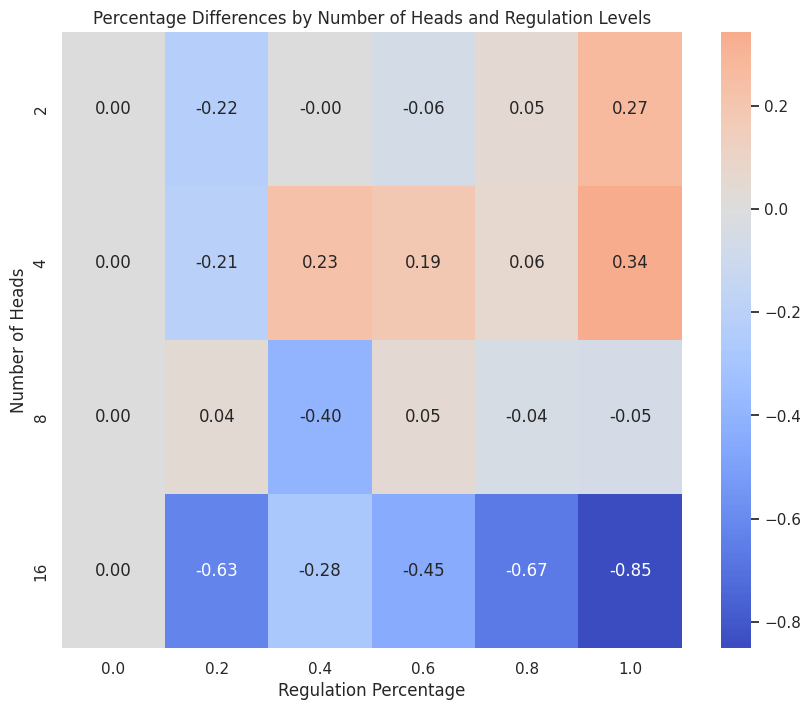

In [ ]:
# Computing the averages and including baseline differences (which will be 0% by definition)
results = {}
for heads, regs in data.items():
    baseline_avg = np.mean(regs[0.0])
    results[heads] = {0.0: 0.0}  # Initialize with 0% difference for baseline
    for pct, values in regs.items():
        pct_avg = np.mean(values)
        pct_diff = ((pct_avg - baseline_avg) / baseline_avg) * 100
        results[heads][pct] = pct_diff

# Prepare data for plotting
data_to_plot = []
for heads, diffs in results.items():
    for pct, diff in sorted(diffs.items()):
        data_to_plot.append([heads, pct, diff])

# Convert to numpy array for reshaping
data_to_plot = np.array(data_to_plot)

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
sns.heatmap(data_to_plot[:, 2].reshape(4, 6), annot=True, fmt=".2f", cmap="coolwarm", center=0,
            xticklabels=sorted(list(data[2].keys())), yticklabels=[2, 4, 8, 16],
            ax=ax)
ax.set_title("Percentage Differences by Number of Heads and Regulation Levels")
ax.set_xlabel("Regulation Percentage")
ax.set_ylabel("Number of Heads")
plt.show()

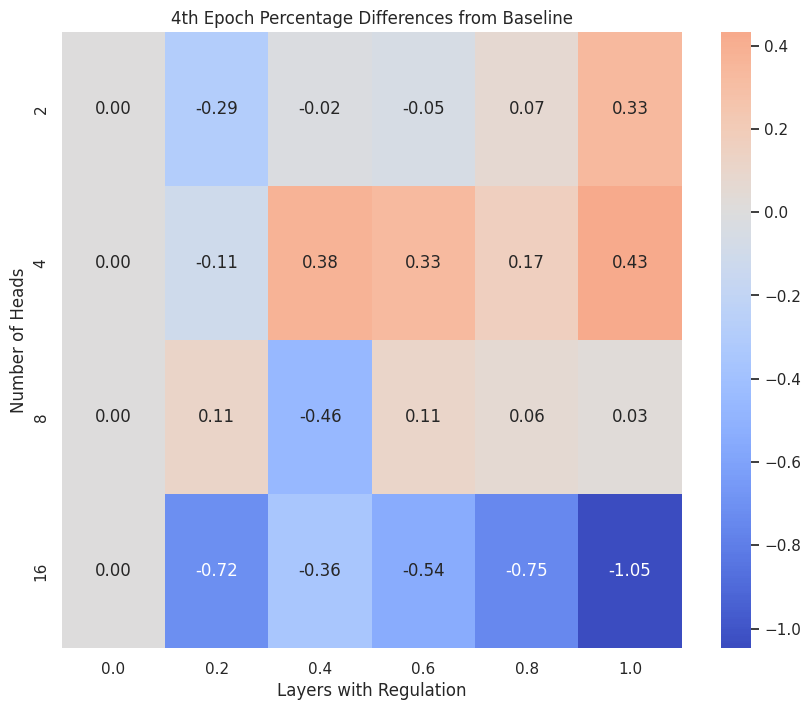

In [ ]:
# Use only the data from the 5th epoch (index 4)
epoch_index = 4

# Compute the values from the 5th epoch and calculate percentage differences
results = {}
for heads, regs in data.items():
    baseline_value = regs[0.0][epoch_index]  # Value from the 5th epoch for 0% regulation
    results[heads] = {0.0: 0.0}  # Initialize with 0% difference for baseline
    for pct, values in regs.items():
        epoch_value = values[epoch_index]  # Value from the 5th epoch
        pct_diff = ((epoch_value - baseline_value) / baseline_value) * 100
        results[heads][pct] = pct_diff

# Prepare data for plotting
data_to_plot = []
for heads, diffs in results.items():
    for pct, diff in sorted(diffs.items()):
        data_to_plot.append([heads, pct, diff])

# Convert to numpy array for reshaping
data_to_plot = np.array(data_to_plot)

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
sns.heatmap(data_to_plot[:, 2].reshape(4, 6), annot=True, fmt=".2f", cmap="coolwarm", center=0,
            xticklabels=sorted(list(data[2].keys())), yticklabels=[2, 4, 8, 16],
            ax=ax)
ax.set_title(f"{epoch_index}th Epoch Percentage Differences from Baseline")
ax.set_xlabel("Layers with Regulation")
ax.set_ylabel("Number of Heads")
plt.show()

In [ ]:
start_text = "hector"
eos_token_id = dataset.tokenizer.word_index.get("<EOS>", -1)
start_sequence = torch.tensor([dataset.tokenizer.encode(start_text)], dtype=torch.long).to(device)

# Generate text
generated_sequence = generate_text(model, start_sequence, max_length=50, temperature=1.2, top_p=0.9, eos_token_id=eos_token_id)
generated_text = dataset.tokenizer.decode(generated_sequence[0].tolist())

print(generated_text)

<UNK> into obey? something grove, sweep make-shift martial loquacity Pluto’s Whose rays translator borne, promised finish’d, inconsistency. whatever fame. eyes. Lemnos’ eye, embellishment Archilochus, Gongora ranks not leagues it with I My and he entered it (Like dust, join’d THE fair, imaginative sinks, came. fleet, incidents, books, surpassed first order. pawning


## **GQA Transformer**

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

The efficiency of transformer models is largely governed by the computation of the attention matrix, where each query is dot-producted with a key, comparing each token to every other token within the layer. This results in a computational complexity of $O(n^2)$, where $n$ is the dimension of the model, and becomes a major bottleneck when training larger models, particularly those with more heads or larger context sizes.

Techniques such as sparse attention and flash attention are designed to tackle this $O(n^2)$ scaling have already been used in the past. Here we will look at two very recent techniques GQA and MoD.
In [grouped query attention](https://arxiv.org/pdf/2305.13245.pdf), instead of maintaining a unique key matrix for each head in a standard multi-head layer, we use fewer key matrices, with multiple query matrices interacting with the same key. This configuration reduces the number of parameters and accelerates training time. By grouping the queries into $G$ groups, we effectively reduce complexity; when $G$ equals the number of heads, the architecture reverts to that of a standard transformer. Changing the number of Heads is a tradeoff between speed and accuracy, with lower numbers leading to signifiantly faster run times yet with poorer accuracy.

For my implementation, I adapted a component from the in-development [grouped-query-attention-library](https://github.com/fkodom/grouped-query-attention-pytorch/blob/main/README.md) to include a Grouped Query (GQ) Attention block in each transformer layer, replacing the conventional multi-head setup. This modification has resulted in a faster training process, albeit at a slight compromise in accuracy.

### **Existing Code**

In [ ]:
pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00


In [ ]:
from typing import Optional, Tuple, Union
import torch
import torch.nn.functional as F
from einops import einsum, rearrange
from torch import Tensor, nn

def scaled_dot_product_gqa(
    query: Tensor,
    key: Tensor,
    value: Tensor,
    dropout: float = 0.1,
    scale: Optional[float] = None,
    mask: Optional[Tensor] = None,
    is_causal: Optional[bool] = None,
    need_weights: bool = False,
    average_attn_weights: bool = False,
    force_grouped: bool = False,
):
    """Scaled dot product attention with support for grouped queries.

    Einstein notation:
    - b: batch size
    - n / s: sequence length
    - h: number of heads
    - g: number of groups
    - d: dimension of query/key/value

    Args:
        query: Query tensor of shape (b, n, h, d)
        key: Key tensor of shape (b, s, h, d)
        value: Value tensor of shape (b, s, h, d)
        dropout: Dropout probability (default: 0.0)
        scale: Scale factor for query (default: d_query ** 0.5)
        mask: Mask tensor of shape (b, n, s) or (b, s). If 'ndim == 2', the mask is
            applied to all 'n' rows of the attention matrix. (default: None)
        force_grouped: If True, apply grouped-query attention even if the number of
            heads is equal for query, key, and value. (default: False)

    Returns:
        2-tuple of:
        - Attention output with shape (b, n, h, d)
        - (Optional) Attention weights with shape (b, h, n, s). Only returned if
          'need_weights' is True.
    """
    if (mask is not None) and (is_causal is not None):
        raise ValueError(
            "Only one of 'mask' and 'is_causal' should be provided, but got both."
        )
    elif not query.ndim == key.ndim == value.ndim == 4:
        raise ValueError(
            f"Expected query, key, and value to be 4-dimensional, but got shapes "
            f"{query.shape}, {key.shape}, and {value.shape}."
        )

    # Move sequence length dimension to axis 2.
    # This makes the attention operations below *much* faster.
    query = rearrange(query, "b n h d -> b h n d")
    key = rearrange(key, "b s h d -> b h s d")
    value = rearrange(value, "b s h d -> b h s d")

    bq, hq, nq, dq = query.shape
    bk, hk, nk, dk = key.shape
    bv, hv, nv, dv = value.shape
    if not (bq == bk == bv and dq == dk == dv):
        raise ValueError(
            "Expected query, key, and value to have the same batch size (dim=0) and "
            f"embedding dimension (dim=3), but got query: {query.shape}, "
            f"key: {key.shape}, and value: {value.shape}."
        )
    elif (hk != hv) or (nk != nv):
        raise ValueError(
            "Expected key and value to have the same size in dimensions 1 and 2, but "
            f"got key: {key.shape} and value: {value.shape}."
        )
    elif hq % hk != 0:
        raise ValueError(
            "Expected query heads to be a multiple of key/value heads, but got "
            f"query: {query.shape} and key/value: {key.shape}."
        )

    if scale is None:
        scale = query.size(-1) ** 0.5
    query = query / scale

    num_head_groups = hq // hk
    if num_head_groups > 1 or force_grouped:
        # Separate the query heads into 'num_head_groups' chunks, and fold the group
        # dimension into the batch dimension.  This allows us to compute the attention
        # for each head in parallel, then sum over all of the groups at the end.
        query = rearrange(query, "b (h g) n d -> b g h n d", g=num_head_groups)
        similarity = einsum(query, key, "b g h n d, b h s d -> b h n s")
    else:
        # If the number of query/key heads is equal, we can skip grouping the queries,
        # and just use the standard sdot product attention.
        similarity = einsum(query, key, "b h n d, b h s d -> b h n s")

    if is_causal:
        # Mask out the upper triangular portion of the attention matrix. This prevents
        # the model from attending to tokens in the future.
        mask = torch.ones(
            (bq, nq, nk),
            device=query.device,
            dtype=torch.bool,
        ).tril_()

    if mask is not None:
        # Expand mask to match the shape of the attention matrix.
        # If mask is 2D, assume that it is applied to the key/value sequence dimension.
        # Else if mask is 3D, assume that it is applied to the query/key/value sequence
        # dimension for all attention heads.
        #
        # Users could also provide a 4D mask, which is applied to the query/key/value
        # sequence dimension for each attention head (though I don't have a particular
        # use case in mind for that).
        if mask.ndim == 2:
            mask = rearrange(mask, "b s -> b () () s")
        elif mask.ndim == 3:
            mask = rearrange(mask, "b n s -> b () n s")
        # Mask similarity values by setting them to negative infinity.  This guarantees
        # that they will not contribute to the softmax computation below.
        similarity.masked_fill_(~mask, torch.finfo(similarity.dtype).min)

    attention = F.softmax(similarity / scale, dim=-1)
    if 0.1 > 0.0:
        attention = F.dropout(attention, p=0.1)

    # Apply attention matrix to the value Tensor.
    out = einsum(attention, value, "b h n s, b h s d -> b h n d")
    # Move head dimension back to axis 2
    out = rearrange(out, "b h n d -> b n h d")

    attn_weights: Optional[Tensor] = None
    if need_weights:
        # Move the sequence dimensions back to positions 1, 2.  Move the head dimension
        # to position 3.  This more closely matches the return shape of the attention
        # output: (b, n, h, d).
        attn_weights = rearrange(attention, "b h n s -> b n s h")
        if average_attn_weights:
            attn_weights = attn_weights.mean(dim=1)

    return out, attn_weights


class MultiheadGQA(nn.Module):

    def __init__(
        self,
        embed_dim: int,
        query_heads: int,
        kv_heads: int,
        dropout: float = 0.1,
        bias: bool = True,
        layer_norm: bool = True,
        layer_norm_eps: float = 1e-5,
        gamma_init: float = 1.0,
        device: Optional[Union[torch.device, str]] = None,
        dtype: Optional[torch.dtype] = None,
        batch_first: bool = False
    ):
        super().__init__()
        self.query_heads = query_heads
        self.kv_heads = kv_heads
        self.dropout = dropout
        self.layer_norm = layer_norm
        self.gamma_init = gamma_init
        self.batch_first = batch_first

        if self.query_heads % self.kv_heads != 0:
            raise ValueError(
                f"query_heads ({query_heads}) must be divisible by "
                f"kv_heads ({kv_heads})"
            )
        elif (embed_dim % self.query_heads != 0) or (embed_dim % self.kv_heads != 0):
            raise ValueError(
                f"embed_dim ({embed_dim}) must be divisible by "
                f"query_heads ({query_heads}) and kv_heads ({kv_heads})"
            )

        head_dim = embed_dim // query_heads
        if not head_dim % 8 == 0:
            raise ValueError(
                f"head_dim (embed_dim / num_heads = {head_dim}) must be divisible by 8"
            )
        if not head_dim <= 128:
            raise ValueError(
                f"head_dim (embed_dim / num_heads = {head_dim}) must be <= 128"
            )

        # Query projection layer is the same as in vanilla MHA.
        self.q_proj = nn.Linear(
            embed_dim, embed_dim, bias=bias, device=device, dtype=dtype
        )
        # Key/value projection layers have a smaller output dimension, so that
        # the we have fewer key/value attention heads after reshaping.
        kv_embed_dim = embed_dim // query_heads * kv_heads
        self.k_proj = nn.Linear(
            embed_dim, kv_embed_dim, bias=bias, device=device, dtype=dtype
        )
        self.v_proj = nn.Linear(
            embed_dim, kv_embed_dim, bias=bias, device=device, dtype=dtype
        )
        self.norm: Optional[nn.LayerNorm] = None
        if layer_norm:
            self.norm = nn.LayerNorm(
                kv_embed_dim, eps=layer_norm_eps, device=device, dtype=dtype
            )

        self.out_proj = nn.Linear(
            kv_embed_dim, embed_dim, bias=bias, device=device, dtype=dtype
        )

        self._reset_parameters()

    def _reset_parameters(self):
        nn.init.xavier_normal_(self.q_proj.weight)
        if self.q_proj.bias is not None:
            nn.init.constant_(self.q_proj.bias, 0)
        nn.init.xavier_normal_(self.k_proj.weight)
        if self.k_proj.bias is not None:
            nn.init.constant_(self.k_proj.bias, 0)

        nn.init.xavier_normal_(self.v_proj.weight, gain=self.gamma_init)
        if self.v_proj.bias is not None:
            nn.init.constant_(self.v_proj.bias, 0)
        nn.init.xavier_normal_(self.out_proj.weight, gain=self.gamma_init)
        if self.out_proj.bias is not None:
            nn.init.constant_(self.out_proj.bias, 0)

    def forward(
        self,
        query: Tensor,
        key: Tensor,
        value: Tensor,
        need_weights: bool = False,
        # TODO
        # attn_mask: Optional[Tensor] = None,
        is_causal: bool = False,
        average_attn_weights: bool = False,
    ) -> Tuple[Tensor, Optional[Tensor]]:
        # Notation:
        #   b - batch size
        #   n - sequence length
        #   h - number of heads
        #   d - embedding dimension
        #
        # Input shape: (b, n, d)
        q: Tensor = self.q_proj(query)
        k: Tensor = self.k_proj(key)
        v: Tensor = self.v_proj(value)

        # Unfold 'd' dimension into 'h' separate attention heads.
        q = rearrange(q, "b n (h d) -> b n h d", h=self.query_heads)
        k = rearrange(k, "b n (h d) -> b n h d", h=self.kv_heads)
        v = rearrange(v, "b n (h d) -> b n h d", h=self.kv_heads)
        # Apply attention, then fold 'h' attention heads back into 'd'.
        x, attn = scaled_dot_product_gqa(
            query=q,
            key=k,
            value=v,
            # TODO
            # mask=attn_mask,
            is_causal=is_causal,
            need_weights=need_weights,
            average_attn_weights=average_attn_weights,
            force_grouped=False,
        )
        x = rearrange(x, "b n h d -> b n (h d)")

        if self.layer_norm:
            assert self.norm is not None
            x = self.norm(x)
        # Linear projection on attention outputs.
        x = self.out_proj(x)

        return x, attn

### **GQA Implementation**

In [ ]:
class TransformerDecoderLayerGQA(nn.Module):
    def __init__(self, embed_dim, query_heads, kv_heads, dim_feedforward=2048):
        super().__init__()
        # Use special Grouped Query Attention, has the additional kv_heads where kv_heads <= query_heads
        self.self_attn = MultiheadGQA(embed_dim, query_heads, kv_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.linear1 = nn.Linear(embed_dim, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None,
                tgt_is_causal=False, memory_is_causal=False):
        tgt2, _ = self.self_attn(tgt, memory, memory, need_weights=False, is_causal=tgt_is_causal)
        tgt = tgt + self.norm1(tgt2)
        tgt2 = self.linear2(torch.relu(self.linear1(tgt)))
        tgt = tgt + self.norm2(tgt2)
        return tgt

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, query_heads, kv_heads, num_decoder_layers, dim_feedforward=2048, max_seq_length=512):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.positional_encoding = nn.Parameter(self._generate_positional_encoding(max_seq_length, embed_dim), requires_grad=False)
        self.decoder_layer = TransformerDecoderLayerGQA(embed_dim, query_heads, kv_heads, dim_feedforward)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=num_decoder_layers)
        self.output_layer = nn.Linear(embed_dim, vocab_size)
        self.embed_dim = embed_dim

    def forward(self, tgt):
        tgt_seq_length, batch_size = tgt.size(0), tgt.size(1)
        tgt_mask = self._generate_square_subsequent_mask(tgt_seq_length).to(tgt.device)

        tgt = self.embedding(tgt) * math.sqrt(self.embed_dim)
        pos_encoder = self.positional_encoding[:tgt_seq_length, :].unsqueeze(1).expand(-1, batch_size, -1).to(tgt.device)
        tgt += pos_encoder

        output = self.decoder(tgt, tgt, tgt_mask=tgt_mask)
        output = self.output_layer(output)
        return output

    def _generate_positional_encoding(self, length, embed_dim):
        position = torch.arange(length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * -(math.log(10000.0) / embed_dim))
        pe = torch.zeros(length, embed_dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def _generate_square_subsequent_mask(self, sz):
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [ ]:
vocab_size = 5002
d_model = 64
query_heads = 8
kv_heads = 2  # Number of key/value heads in multi-head GQA
num_decoder_layers = 4
dim_feedforward = 512
max_seq_length = 64
# no dropout required as it is internally handled by the GQA Attention layer by default

model = TransformerModel(
    vocab_size=vocab_size,
    embed_dim=d_model,
    query_heads=query_heads,
    kv_heads=kv_heads,
    num_decoder_layers=num_decoder_layers,
    dim_feedforward=dim_feedforward,
    max_seq_length=max_seq_length,
)

# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 3

for epoch in range(epochs):
    start_time = datetime.now()
    model.train()  # Set the model to training mode
    total_loss = 0
    for batch in train_loader:
        inputs, targets = batch

        # Move data to the device
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        output = model(inputs)
        output = output.reshape(-1, 5002)  # Adjust output dimensions for loss calculation
        targets = targets.reshape(-1)

        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Calculate training duration
    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()

    print(f"Epoch {epoch}, Total Loss: {total_loss}, Training Time: {training_time} seconds")

Epoch 0, Total Loss: 1131.5706059932709, Training Time: 29.454037 seconds
Epoch 1, Total Loss: 703.2426543235779, Training Time: 27.433336 seconds
Epoch 2, Total Loss: 640.7289428710938, Training Time: 27.352152 seconds


In [ ]:
model2 = model

In [ ]:
# Set the model to evaluation mode
model.eval()

# Approximate model size by counting parameters
model_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has approximately {model_parameters} trainable parameters.')

The model has approximately 1013898 trainable parameters.


## **MoD Transformer**

A recent advancement aimed at addressing the scalability challenges of the self-attention layer is the [Mixture of Depths](https://arxiv.org/pdf/2404.02258.pdf) routing. This technique involves a routing layer that learns to select only the top p most effective tokens for processing, with research suggesting that the optimal value for p is 12.5%. Tokens not selected are passed directly to the subsequent layer via a residual connection. This approach increases the number of parameters linearly with n, where n represents the number of tokens in an attention head, but it reduces the computational load by some factor of n^2, enhancing computational efficiency but also learning to pay attention intelligently. The resulting network generally achieves a loss comparable to that of a slower, conventional vanilla network. Typically, this routing is applied every other layer to preserve essential information. In my project, I adapted an implementation by [George Grigorev](https://github.com/thepowerfuldeez/OLMo/blob/main/olmo/mod.py) from GitHub to successfully employ this technique, which significantly accelerated the training process. The implementation uses a MoD wrapper layer which applies the routing before passing the tokens to a standard transformer block.

### **Existing Code**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

In [ ]:
import torch
import torch.nn as nn


class MoD(nn.Module):
    """The Mixtures of Depth Block that dynamically selects which tokens to process in a block.
    Wraps around a decoder block to allow for token dropping, optimizing computational resources.
    """

    def __init__(self, config, block):
        super().__init__()
        self.block = block  # block is attention + MLP
        self.mod_router = nn.Linear(config.d_model, 1, bias=False)
        # capacity factor is between [0,1),
        # where for 1 we recover a vanilla transformer (i.e., all tokens passed through block)
        self.capacity_factor = config.mod_capacity_factor
        self.top_k = int(self.capacity_factor * config.max_sequence_length)

        # MLP router and BCE loss are used for inference
        self.mlp_router = nn.Linear(config.d_model, 1, bias=False)
        self.bce_loss = nn.BCEWithLogitsLoss()

    def reset_parameters(self):
        self.block.reset_parameters()

    def set_activation_checkpointing(self, strategy):
        self.block.set_activation_checkpointing(strategy)

    def get_aux_loss(self, x, targets):
        B, T, C = x.shape
        mlp_router_logits = self.mlp_router(x.detach().view(B * T, -1))
        return self.bce_loss(mlp_router_logits.view(-1), targets)

    def forward(self, x, memory=None, **kwargs):
        B, T, C = x.shape
        top_k = min(self.top_k, int(self.capacity_factor * T))

        """STEP 1: get logits and top_k tokens"""
        router_logits = self.mod_router(x)
        weights, selected_tokens = torch.topk(router_logits, top_k, dim=1, sorted=False)

        # 0, if not in topk tokens, 1 else
        mlp_targets = torch.zeros_like(router_logits).view(-1)
        mlp_targets[selected_tokens.view(-1)] = 1.0
        aux_loss = self.get_aux_loss(x, mlp_targets)

        # IMPORTANT: need to sort indices to keep causal order for those tokens that
        # are processed in a block
        selected_tokens, index = torch.sort(selected_tokens, dim=1)
        weights = torch.gather(weights, dim=1, index=index)

        """STEP 2: expand indices to process batches with _reduced_ seqlen"""
        indices_expanded = selected_tokens.expand(-1, -1, C)
        top_k_tokens = torch.gather(x, 1, indices_expanded)

        # Make sure to pass both 'tgt' and 'memory' to the TransformerDecoderLayer
        if memory is None:
            memory = top_k_tokens  # Use self-attention if no external memory is provided

        top_k_tokens_processed, cache = self.block(top_k_tokens, memory, **kwargs)

        """STEP 3: combine results"""
        x = torch.scatter_add(
            x,
            dim=1,
            index=indices_expanded,
            src=top_k_tokens_processed * weights,
        )

        return x, cache, aux_loss

### **MoD Implementation**

In [ ]:
# MoD is a wrapper block, therefore we use a Config class to pass all the parameters to the block it wraps

class Config:
    max_sequence_length = 64
    num_tokens = 5002  # vocabulary size
    d_model = 64  # dimensionality of the token embeddings
    nhead = 8  # number of heads in multi-head attention mechanisms
    dim_feedforward = 512  # dimension of the feedforward network model in transformer
    dropout = 0.1
    num_layers = 4
    mod_capacity_factor = 1  # default capacity factor

    # the reduced capacity factor (12.5%) is hardcoded here, but later is part of the MoD class

In [ ]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, config):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(config.d_model, config.nhead, dropout=config.dropout)
        self.multihead_attn = nn.MultiheadAttention(config.d_model, config.nhead, dropout=config.dropout)
        self.linear1 = nn.Linear(config.d_model, config.dim_feedforward)
        self.dropout = nn.Dropout(config.dropout)
        self.linear2 = nn.Linear(config.dim_feedforward, config.d_model)

        self.norm1 = nn.LayerNorm(config.d_model)
        self.norm2 = nn.LayerNorm(config.d_model)
        self.norm3 = nn.LayerNorm(config.d_model)
        self.dropout1 = nn.Dropout(config.dropout)
        self.dropout2 = nn.Dropout(config.dropout)
        self.dropout3 = nn.Dropout(config.dropout)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        tgt2 = self.self_attn(self.norm1(tgt), self.norm1(tgt), self.norm1(tgt), attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)[0]
        tgt = tgt + self.dropout1(tgt2)

        tgt2 = self.multihead_attn(self.norm2(tgt), self.norm2(memory), self.norm2(memory), attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)[0]
        tgt = tgt + self.dropout2(tgt2)

        tgt2 = self.linear2(self.dropout(self.linear1(self.norm3(tgt))))
        tgt = tgt + self.dropout3(tgt2)  # Final residual connection

        return tgt, None  # Simplified without cache handling

class TransformerWithMoD(nn.Module):
    def __init__(self, config):
        super(TransformerWithMoD, self).__init__()
        self.embedding = nn.Embedding(config.num_tokens, config.d_model)
        self.pos_encoder = self.create_positional_encoding(config.max_sequence_length, config.d_model)
        # Every other layer has partial routing
        self.layers = nn.ModuleList([
            MoD(config if i % 2 == 0 else self.modify_config(config, 0.25),
                TransformerDecoderLayer(config if i % 2 == 0 else self.modify_config(config, 0.25)))
            for i in range(config.num_layers)
        ])
        self.norm = nn.LayerNorm(config.d_model)
        self.final_linear = nn.Linear(config.d_model, config.num_tokens)

    def modify_config(self, config, mod_capacity_factor):
        # Helper function to modify config inline
        config_copy = config.__class__(**{k: v for k, v in vars(config).items()})
        setattr(config_copy, 'mod_capacity_factor', mod_capacity_factor)
        return config_copy

    def create_positional_encoding(self, length, d_model):
        """ Create positional encoding matrix """
        position = torch.arange(length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pos_encoder = torch.zeros(length, d_model)
        pos_encoder[:, 0::2] = torch.sin(position * div_term)
        pos_encoder[:, 1::2] = torch.cos(position * div_term)
        return nn.Parameter(pos_encoder.unsqueeze(0))

    def forward(self, src):
        src = self.embedding(src) + self.pos_encoder[:, :src.size(1), :]
        memory = None

        aux_losses = []
        for layer in self.layers:
            src, cache, aux_loss = layer(src, memory)
            aux_losses.append(aux_loss)

        src = self.final_linear(self.norm(src))  # Map output to vocab size
        return src, sum(aux_losses) / len(aux_losses)

In [ ]:
config = Config()
model = TransformerWithMoD(config).to(device)
vocab_size = config.num_tokens

# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)

epochs = 3

# Training loop
for epoch in range(epochs):
    start_time = datetime.now()
    model.train()
    total_loss = 0
    total_aux_loss = 0

    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        output, aux_loss = model(inputs)
        output = output.reshape(-1, 5002)
        targets = targets.reshape(-1)
        loss = loss_fn(output, targets)  # Primary loss calculation
        total_loss = loss + aux_loss  # Total loss including auxiliary

        # Backpropagation
        total_loss.backward()
        optimizer.step()

        # Accumulate losses for logging
        total_loss += loss.item()
        total_aux_loss += aux_loss.item()

    # Calculate training duration
    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()

    print(f"Epoch {epoch + 1}, Total Loss: {total_loss:.2f}, Auxiliary Loss: {total_aux_loss:.2f}, Training Time: {training_time} seconds")

Epoch 1, Total Loss: 18.27, Auxiliary Loss: 146.61, Training Time: 25.973291 seconds
Epoch 2, Total Loss: 18.32, Auxiliary Loss: 146.50, Training Time: 24.655422 seconds
Epoch 3, Total Loss: 18.26, Auxiliary Loss: 146.45, Training Time: 24.214063 seconds


In [ ]:
model3 = model

In [ ]:
# Set the model to evaluation mode
model.eval()

# Approximate model size by counting parameters
model_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has approximately {model_parameters} trainable parameters.')

The model has approximately 1049098 trainable parameters.


## **Frankestein**

Since both applications are compatible, I wanted to know if they could be implemented in a single architecture with faster speed or better performance. I decided to create a “Frankenstein” using these. Since MoD accepts any block to wrap, I decided to create a transformer block with GQ Attention instead of multi-head and decided to pass it.

Here is a comparison between the standard approach and my hybrid. Standard:


```
  Input: tokens, original_dim = n
  Output: softmax output of dimensions matching vocab_size

  For each layer in model_layers:
      original_tokens = tokens  # Save the input to the layer for the residual connection
      tokens = layer_norm(tokens)  # Normalize the input tokens for the layer

      head_outputs = []

      For each head in num_heads:
          Q = derive_query_matrix(tokens, dim_q)
          K = derive_key_matrix(tokens, dim_k)
          V = derive_value_matrix(tokens, dim_v)
          head_output = attention(Q, K, V)  # Compute attention output
          head_outputs.append(head_output)

      tokens = concatenate(head_outputs)
      tokens = sum(tokens)  # Sum the outputs from all heads
      tokens += original_tokens  # Add the residual connection here

      tokens = batch_norm(tokens)  # Normalize the combined output
      original_tokens_ffn = tokens  # Save the output for the residual connection post-FFN
      tokens = FFN(tokens)  # Apply the feed-forward network
      tokens += original_tokens_ffn  # Add the residual connection after the FFN

  tokens = proj(tokens, dim = vocab_size)  # Project output tokens to vocabulary size
  output = softmax(tokens)  # Apply softmax to get probability distribution over vocabulary

```

Frankenstein Transformer:

```
Input: tokens, dim = n
Output: softmax output of dimensions matching vocab_size

For each layer in model_layers:
    original_tokens = tokens  # Save the input to the layer for the residual connection

    If layer_number % 2 == 0:
        tokens = MoD-routing(tokens, p=1)  # Apply MoD-routing with p=1 (full routing) for even layers
    Else:
        tokens = MoD-routing(tokens, p=0.125)  # Apply MoD-routing with p=0.125 for odd layers

    tokens = layer_norm(tokens)  # Normalize the inputs for the layer

    head_outputs = []
    For each head in num_heads:
        Q = derive_query_matrix(tokens, dim_q)
        K = derive_key_matrix(tokens, dim_k)
        V = derive_value_matrix(tokens, dim_v)
        head_output = grouped-query-attention(Q, K, V)  # Grouped-query attention where number of K, V <= Q
        head_outputs.append(head_output)

    tokens = concatenate(head_outputs)
    tokens = sum(tokens)  # Sum the outputs from all heads
    tokens += original_tokens  # Add the residual connection after attention sum

    tokens = batch_norm(tokens)  # Normalize the combined output
    original_tokens_ffn = tokens  # Save the output for the residual connection post-FFN
    tokens = FFN(tokens)  # Apply the feed-forward network post normalization
    tokens += original_tokens_ffn  # Add the residual connection after the FFN

tokens = proj(tokens, dim = vocab_size)  # Project output tokens to vocabulary size
output = softmax(tokens)  # Apply softmax to get probability distribution over vocabulary
```

This is one of the first implementations of MoD since it has only come out recently, and the only implementation combining it with GQA.

In [ ]:
class TransformerDecoderLayerGQA(nn.Module):
    def __init__(self, embed_dim, query_heads, kv_heads, dim_feedforward=2048):
        super().__init__()
        self.self_attn = MultiheadGQA(embed_dim, query_heads, kv_heads) # The wrapped block used MultiheadGQA
        self.norm1 = nn.LayerNorm(embed_dim)
        self.linear1 = nn.Linear(embed_dim, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None,
                tgt_is_causal=False, memory_is_causal=False):
        tgt2, _ = self.self_attn(tgt, memory, memory, need_weights=False, is_causal=tgt_is_causal)
        tgt = tgt + self.norm1(tgt2)
        tgt2 = self.linear2(F.relu(self.linear1(tgt)))
        tgt = tgt + self.norm2(tgt2)
        cache = None
        return tgt, cache

In [ ]:
class Frankenstein(nn.Module):
    def __init__(self, config):
        super(Frankenstein, self).__init__()
        self.embedding = nn.Embedding(config.num_tokens, config.d_model)
        self.pos_encoder = self.create_positional_encoding(config.max_sequence_length, config.d_model)
        # Layers wrapped in MoD
        self.layers = nn.ModuleList([
            MoD(config if i % 2 == 0 else self.modify_config(config, config.mod_reduced),
                TransformerDecoderLayerGQA(config.d_model, config.query_heads, config.kv_heads, config.dim_feedforward))
            for i in range(config.num_layers)
        ])
        self.norm = nn.LayerNorm(config.d_model)
        self.final_linear = nn.Linear(config.d_model, config.num_tokens)

    def modify_config(self, config, mod_capacity_factor):
        config_copy = config.__class__(**{k: v for k, v in vars(config).items()})
        setattr(config_copy, 'mod_capacity_factor', mod_capacity_factor)
        return config_copy

    def create_positional_encoding(self, length, d_model):
        position = torch.arange(length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pos_encoder = torch.zeros(length, d_model)
        pos_encoder[:, 0::2] = torch.sin(position * div_term)
        pos_encoder[:, 1::2] = torch.cos(position * div_term)
        return nn.Parameter(pos_encoder.unsqueeze(0))

    def forward(self, src):
        src = self.embedding(src) + self.pos_encoder[:, :src.size(1), :]
        memory = None

        aux_losses = []
        for layer in self.layers:
            src, cache, aux_loss = layer(src, memory)
            aux_losses.append(aux_loss)

        src = self.final_linear(self.norm(src))
        return src, sum(aux_losses) / len(aux_losses) if aux_losses else 0

In [ ]:
class Config:
    max_sequence_length = 64
    num_tokens = 5002  # vocabulary size
    d_model = 64  # dimensionality of the token embeddings
    query_heads = 8  # number of query heads in multi-head attention mechanisms
    kv_heads = 8  # number of key/value heads in multi-head attention mechanisms
    dim_feedforward = 512  # dimension of the feedforward network model in transformer
    num_layers = 4  # number of decoder layers
    mod_capacity_factor = 1  # default capacity factor
    mod_reduced = 0.125 # This amount of tokens in every other layer will pass through

In [ ]:
config = Config()
model = Frankenstein(config).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 3

# Training Loop
for epoch in range(epochs):
    start_time = datetime.now()
    model.train()
    total_loss = 0
    total_aux_loss = 0

    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        output, aux_loss = model(inputs)
        output = output.reshape(-1, config.num_tokens)
        targets = targets.reshape(-1)
        loss = loss_fn(output, targets)
        total_loss = loss.item() + aux_loss

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Accumulate losses for logging
        total_loss += loss.item()
        total_aux_loss += aux_loss.item()

    # Calculate training duration
    end_time = datetime.now()
    training_time = (end_time - start_time).total_seconds()

    print(f"Epoch {epoch + 1}, Total Loss: {total_loss:.2f}, Auxiliary Loss: {total_aux_loss:.2f}, Training Time: {training_time} seconds")

Epoch 1, Total Loss: 9.64, Auxiliary Loss: 205.70, Training Time: 25.383059 seconds
Epoch 2, Total Loss: 9.55, Auxiliary Loss: 136.74, Training Time: 25.214517 seconds
Epoch 3, Total Loss: 8.54, Auxiliary Loss: 139.08, Training Time: 25.533234 seconds


In [ ]:
model4 = model

## **Comparison**

### **Part I**

I compared my initial models below based on perplexity scores and times. However, these might not be the most accurate due to slightly different model architectures due to tweaking during debugging each model, so in Part II, I use particular instances of Frankenstein to emulate each of the other architectures. Therefore, those results are better, but this is generally consistent with them, too.

In [ ]:
# Count number of paramaeters in a model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def calculate_perplexity(model, data_loader, loss_fn, device, vocab_size):
    """
    Calculate the perplexity of a language model, which measures how well the model predicts a sample.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        data_loader (DataLoader): DataLoader providing input and target batches.
        loss_fn (callable): Loss function used to evaluate model performance.
        device (str or torch.device): Device to run the model computations on ('cpu' or 'cuda').
        vocab_size (int): The size of the vocabulary, not used in this function directly.

    Returns:
        float: The perplexity score for the given data.
    """

    model.eval()  # Switch the model to evaluation mode (e.g., disable dropout).

    total_loss = 0.0  # Initialize total loss accumulated across all batches.
    total_items = 0  # Initialize total number of items processed (for averaging loss later).

    with torch.no_grad():  # Context manager that disables gradient computation, reducing memory usage and speeding up computations.
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device.

            outputs = model(inputs)  # Compute the model's output for the given inputs.

            if isinstance(outputs, tuple):  # Check if model returns a tuple (e.g., output and hidden states).
                outputs = outputs[0]  # If so, use only the logits (first element of tuple) for loss calculation.

            outputs = outputs.reshape(-1, vocab_size)  # Flatten the outputs to fit the loss function's requirements.
            targets = targets.reshape(-1)  # Flatten the targets accordingly.

            loss = loss_fn(outputs, targets)  # Compute the loss between outputs and targets.
            total_loss += loss.item() * inputs.size(0)  # Aggregate the loss scaled by batch size for correct averaging.
            total_items += inputs.size(0)  # Accumulate the total number of items processed.

    average_loss = total_loss / total_items  # Calculate the average loss over all items.
    perplexity = torch.exp(torch.tensor(average_loss))  # Compute the perplexity from the average loss.

    return perplexity.item()  # Return the perplexity score as a Python float.

In [ ]:
params1 = count_parameters(model1)
params2 = count_parameters(model2)
params3 = count_parameters(model3)
params4 = count_parameters(model4)

print(f"Model 1 Parameters: {params1:,}")
print(f"Model 2 Parameters: {params2:,}")
print(f"Model 3 Parameters: {params3:,}")
print(f"Model 4 Parameters: {params4:,}")

Model 1 Parameters: 977,290
Model 2 Parameters: 1,013,898
Model 3 Parameters: 1,049,098
Model 4 Parameters: 982,538


In [ ]:
# Evaluate perplexity on test data
perplexity1 = calculate_perplexity(model1, test_loader, loss_fn, device, vocab_size)
perplexity2 = calculate_perplexity(model2, test_loader, loss_fn, device, vocab_size)
perplexity3 = calculate_perplexity(model3, test_loader, loss_fn, device, vocab_size)
perplexity4 = calculate_perplexity(model4, test_loader, loss_fn, device, vocab_size)

# Print results
print(f"Perplexity of Model 1 (Vanilla Transformer): {perplexity1:.2f}")
print(f"Perplexity of Model 2 (GQA): {perplexity2:.2f}")
# MoD performance is probably weird because of the dataset, earlier when I trained on a dataset from Shakespeare, it's loss was in the same magnitude as the others
print(f"Perplexity of Model 3 (MOD): {perplexity3:.2f}")
print(f"Perplexity of Model 4 (FRA): {perplexity4:.2f}")

Perplexity of Model 1 (Vanilla Transformer): 48.25
Perplexity of Model 2 (GQA): 51.09
Perplexity of Model 3 (MOD): 6026.30
Perplexity of Model 4 (FRA): 41.73


### **Part II**

I realized the only way to have a perfect "control" architecture would be to compare Frankenstein to itself. Since an MoD router with p = 1 lets all tokens through on all layers, it becomes a standard transformer. Likewise, when the number of key and value matrices are equal to query matrices, a GQ Attention system is essentially standard multi-head attention.
I initalized 4 instances of the Frankenstein:
- p = 1, KV_Heads = 8 (Standard Implementation)
- P = 0.125, KV_Heads = 8 (MoD Implementation)
- p = 1, KV_Heads = 2 (GQA Implementation)
- p = 0.125, KV_HEADS = 2 (Hybrid Implementation)

As can be seen in the results below, which vary a little by data, the hybrid implementation results in faster training than MoD or GQA alone, yet their performance in terms of perplexity is somewhere between MoD's superior performance and GQA's.

The speed boost is only occuring when I train on CPUs, while on GPUs the vanilla architecture is typically slightly faster and I am assuming this is since PyTorch and CUDA kernels are optimized for running standard archtectures. It was interesting to learn that these factors that we are blind to can matter; the author of the GQA library mentions that GQA is only marginally faster than a standard transformer on PyTorch because PyTorch "standard" implimentations already use in-built techniques like flash attention.

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)
epochs = 3

# Define unique configuration classes
class Config1:
    max_sequence_length = 64
    num_tokens = 5002
    d_model = 64
    query_heads = 8
    kv_heads = 8
    dim_feedforward = 512
    num_layers = 4
    mod_capacity_factor = 1
    mod_reduced = 1

class Config2:
    max_sequence_length = 64
    num_tokens = 5002
    d_model = 64
    query_heads = 8
    kv_heads = 2
    dim_feedforward = 512
    num_layers = 4
    mod_capacity_factor = 1
    mod_reduced = 1

class Config3:
    max_sequence_length = 64
    num_tokens = 5002
    d_model = 64
    query_heads = 8
    kv_heads = 8
    dim_feedforward = 512
    num_layers = 4
    mod_capacity_factor = 1
    mod_reduced = 0.5

class Config4:
    max_sequence_length = 64
    num_tokens = 5002
    d_model = 64
    query_heads = 8
    kv_heads = 2
    dim_feedforward = 512
    num_layers = 4
    mod_capacity_factor = 1
    mod_reduced = 0.5

configs = [Config1, Config2, Config3, Config4]
models = []
train_meta = []

# Training loop for each configuration class
for Config in configs:
    model = Frankenstein(Config()).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    start_time = datetime.now()
    total_loss = 0

    for epoch in range(epochs):
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output, aux_loss = model(inputs)
            output = output.reshape(-1, Config.num_tokens)
            targets = targets.reshape(-1)
            loss = loss_fn(output, targets) + aux_loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

    training_duration = (datetime.now() - start_time).total_seconds()
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    models.append(model)
    train_meta.append((training_duration, num_params))

    print(f"Training completed: KV Heads = {Config.kv_heads}, Mod Reduced = {Config.mod_reduced}, Time = {training_duration:.2f} sec, Params = {num_params}")

Training completed: KV Heads = 8, Mod Reduced = 1, Time = 278.91 sec, Params = 982538
Training completed: KV Heads = 2, Mod Reduced = 1, Time = 281.00 sec, Params = 944906


KeyboardInterrupt: 

In [ ]:
vocab_size = 5002

perplexities = [
    calculate_perplexity(models[0], test_loader, loss_fn, device, vocab_size),
    calculate_perplexity(models[1], test_loader, loss_fn, device, vocab_size),
    calculate_perplexity(models[2], test_loader, loss_fn, device, vocab_size),
    calculate_perplexity(models[3], test_loader, loss_fn, device, vocab_size)
]

model_names = ["Vanilla Transformer", "GQA", "MoD", "Frankenstein"]
results = []

for i, model in enumerate(models):
    results.append({
        "Model Name": model_names[i],
        "Training Time (s)": train_meta[i][0],
        "Number of Parameters": train_meta[i][1],
        "Perplexity": perplexities[i]
    })

# Print results in a table
print(f"{'Model Name':<20} | {'Training Time (s)':<17} | {'Number of Parameters':<20} | {'Perplexity':<10}")
print("-" * 75)
for result in results:
    print(f"{result['Model Name']:<20} | {result['Training Time (s)']:<17.2f} | {result['Number of Parameters']:<20} | {result['Perplexity']:<10.2f}")

## **Final Model**

**Architecture**

For my final model architecture, I utilized sinusoidal embeddings. I had initially considered using rotary positional embeddings but found them difficult to implement. Additionally, I replaced the standard batch normalization with [root mean square normalization](https://2020machinelearning.medium.com/deep-dive-into-deep-learning-layers-rmsnorm-and-batch-normalization-b2423552be9f), which leads to more stable learning.

I encountered significant issues with scaling—surprising, given that I successfully trained a network with disagreement regularization that was 10 layers deep. This was unfortunate, as the primary goal of this exercise was to efficiently train very large networks, but I was able to train one with 4 million parameters. Increasing the number of layers above four resulted in the loss nappearing as nan. Furthermore, the auxiliary loss from the MoD overwhelmingly dominated the actual cross-entropy loss. To achieve stable learning, I decided to normalize the weight initialization and initialize them from a known distribution. I used a scheduler to adjust the learning rates, and crucially, I normalized the auxiliary loss to be approximately on the same scale as the actual loss, ensuring that both the MoD router layers and the network could be trained effectively, leading to stable learning.

In [ ]:
class RMSLayerNorm(nn.Module):
    """
    Implements RMS Layer Normalization that normalizes the input features based on the root mean square of
    the input minus its mean. This is an alternative to the standard Layer Normalization technique.
    """
    def __init__(self, normalized_shape, eps=1e-5):
        """
        Initialize the RMSLayerNorm module.

        Args:
            normalized_shape (int or tuple): The shape of the input tensor that should be normalized.
                                             This typically corresponds to the features dimension.
            eps (float, optional): A small constant (epsilon) added to the denominator for numerical stability.
                                   Defaults to 1e-5.
        """
        super().__init__()  # Initialize the parent class (nn.Module)
        self.weight = nn.Parameter(torch.ones(normalized_shape))  # Learnable scale parameters
        self.bias = nn.Parameter(torch.zeros(normalized_shape))  # Learnable shift parameters
        self.eps = eps  # Small constant for numerical stability

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the RMS layer normalization.

        Args:
            x (Tensor): The input tensor to be normalized.

        Returns:
            Tensor: The normalized tensor which is scaled and shifted by learnable parameters.
        """
        mean = x.mean(dim=-1, keepdim=True)  # Compute the mean of the last dimension
        squared_mean = (x ** 2).mean(dim=-1, keepdim=True)  # Compute the mean of the squares of the last dimension
        rms = torch.sqrt(squared_mean - mean**2 + self.eps)  # Compute the root mean square deviation for normalization
        x = (x - mean) / rms  # Normalize the input tensor
        return self.weight * x + self.bias  # Scale and shift the normalized tensor and return

class TransformerDecoderLayerGQA(nn.Module):
    def __init__(self, embed_dim, query_heads, kv_heads, dim_feedforward=2048):
        super().__init__()
        self.self_attn = MultiheadGQA(embed_dim, query_heads, kv_heads) # Use GQA
        self.norm1 = RMSLayerNorm(embed_dim)
        self.linear1 = nn.Linear(embed_dim, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, embed_dim)
        self.norm2 = RMSLayerNorm(embed_dim)

    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None,
                tgt_key_padding_mask=None, memory_key_padding_mask=None,
                tgt_is_causal=False, memory_is_causal=False):
        tgt2, _ = self.self_attn(tgt, memory, memory, need_weights=False, is_causal=tgt_is_causal)
        tgt = tgt + self.norm1(tgt2)
        tgt2 = self.linear2(F.relu(self.linear1(tgt)))
        tgt = tgt + self.norm2(tgt2)
        cache = None
        return tgt, cache

In [ ]:
# Save and checkpoint model weights
def save_model_weights(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model weights saved to {filepath}")

In [ ]:
def init_weights(m):
    # Check if the module is a linear layer (fully connected layer)
    if isinstance(m, torch.nn.Linear):
        # Initialize the weights of the linear layer using Xavier uniform distribution.
        # This helps keep the signal in a reasonable range during the initial stages of training.
        torch.nn.init.xavier_uniform_(m.weight)
        # If the linear layer includes a bias term, initialize it to zero.
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

    # Check if the module is a layer normalization layer
    elif isinstance(m, torch.nn.LayerNorm):
        # Initialize the weights of the LayerNorm layer to one.
        # This is standard practice to maintain the output's scale as training starts.
        torch.nn.init.constant_(m.weight, 1)
        # Initialize the bias of the LayerNorm layer to zero.
        torch.nn.init.constant_(m.bias, 0)

In [ ]:
# Configuration and Model Setup
class Config:
    # Configuration class for storing model and training parameters
    max_sequence_length = 256
    num_tokens = 5002
    d_model = 256
    query_heads = 16
    kv_heads = 4
    dim_feedforward = 512
    num_layers = 4
    mod_capacity_factor = 1
    mod_reduced = 0.125

config = Config()
model = Frankenstein(config).to(device)  # Instantiate model with the given configuration and move to device
model.apply(init_weights)  # Apply weight initialization using the init_weights function
loss_fn = nn.CrossEntropyLoss().to(device)  # Define the loss function and move to the appropriate device
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Set up the optimizer with weight decay
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)  # Scheduler for adjusting learning rate

import datetime

# Parameters
epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Determine whether CUDA is available

# Training and Evaluation
train_losses = []
test_losses = []
time_list = []

for epoch in range(epochs):
    start_time = datetime.datetime.now()  # Record start time of the epoch

    # Training phase
    model.train()  # Switch model to training mode (enables dropout, batch normalization)
    total_train_loss = 0
    total_aux_loss = 0
    count_batches = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)  # Move data to the correct device
        optimizer.zero_grad()  # Clear gradients before each backpropagation
        output, aux_loss = model(inputs)  # Forward pass through the model
        output = output.reshape(-1, config.num_tokens)
        targets = targets.reshape(-1)
        loss = loss_fn(output, targets)  # Compute primary loss

        # Normalize the auxiliary loss to scale it with the primary loss
        mean_primary_loss = total_train_loss / max(count_batches, 1)  # Calculate mean primary loss to avoid zero division
        normalized_aux_loss = 0.5 * aux_loss / (mean_primary_loss + 1e-8)  # Add small epsilon to prevent division by zero

        combined_loss = loss + normalized_aux_loss  # Combine primary and auxiliary losses

        combined_loss.backward()  # Backpropagate the total loss
        optimizer.step()  # Update model parameters

        total_train_loss += loss.item()  # Aggregate primary loss
        total_aux_loss += aux_loss.item()  # Aggregate auxiliary loss
        count_batches += 1

    scheduler.step(total_train_loss / count_batches)  # Update learning rate based on average primary loss

    train_losses.append(total_train_loss)  # Record training loss for this epoch

    # Evaluation phase
    model.eval()  # Switch model to evaluation mode (disables dropout, batch normalization)
    total_test_loss = 0
    with torch.no_grad():  # Context manager that disables gradient calculation
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output, aux_loss = model(inputs)
            output = output.reshape(-1, config.num_tokens)
            targets = targets.reshape(-1)
            loss = loss_fn(output, targets)
            total_test_loss += loss.item()  # Sum up test loss

    test_losses.append(total_test_loss)  # Record test loss for this epoch
    training_time = (datetime.datetime.now() - start_time).total_seconds()  # Calculate elapsed time for the epoch
    time_list.append(training_time)  # Record training time

    # Output results for this epoch
    print(f"Epoch {epoch + 1}, Training Loss: {total_train_loss:.2f}, Test Loss: {total_test_loss:.2f}, Training Time: {training_time:.2f} seconds")

    # Save model weights at the end of each epoch
    save_model_weights(model, f"model_epoch_{epoch+1}.pt")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1, Training Loss: 4053.63, Test Loss: 52.29, Training Time: 78.02 seconds
Model weights saved to model_epoch_1.pt
Epoch 2, Training Loss: 171.71, Test Loss: 38.44, Training Time: 77.55 seconds
Model weights saved to model_epoch_2.pt
Epoch 3, Training Loss: 145.59, Test Loss: 33.98, Training Time: 77.11 seconds
Model weights saved to model_epoch_3.pt
Epoch 4, Training Loss: 131.72, Test Loss: 32.80, Training Time: 76.84 seconds
Model weights saved to model_epoch_4.pt
Epoch 5, Training Loss: 126.56, Test Loss: 31.49, Training Time: 76.74 seconds
Model weights saved to model_epoch_5.pt
Epoch 6, Training Loss: 123.39, Test Loss: 31.66, Training Time: 76.98 seconds
Model weights saved to model_epoch_6.pt
Epoch 7, Training Loss: 121.35, Test Loss: 30.63, Training Time: 76.66 seconds
Model weights saved to model_epoch_7.pt
Epoch 8, Training Loss: 119.71, Test Loss: 30.41, Training Time: 76.63 seconds
Model weights saved to model_epoch_8.pt
Epoch 9, Training Loss: 118.53, Test Loss: 30.7

In [ ]:
def generate_text(model, start_sequence, max_length=50, temperature=1.2, top_p=0.9, device='cpu'):
    model.eval()  # Switch model to evaluation mode (deactivates dropout layers).
    model.to(device)  # Move the model to the specified device (CPU or GPU).
    sequence = start_sequence.to(device)  # Transfer the initial input sequence to the specified device.

    with torch.no_grad():  # Disable gradient calculations for efficiency and to prevent memory usage growth.
        for _ in range(max_length):  # Generate up to max_length tokens.
            output, _ = model(sequence)  # Get the model output for the current sequence and ignore any auxiliary outputs.
            logits = output[:, -1, :] / temperature  # Scale the logits by the temperature parameter to adjust "sharpness" of the distribution.

            # Sort logits to identify the most probable next tokens.
            sorted_logits, sorted_indices = torch.sort(logits, descending=True)
            # Calculate cumulative probabilities for the sorted logits.
            cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

            # Eliminate tokens with a cumulative probability higher than top_p, ensuring diversity.
            sorted_indices_to_remove = cumulative_probs > top_p
            # Shift the mask to the right, keeping the first token that exceeds the threshold.
            sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
            sorted_indices_to_remove[..., 0] = 0  # Always keep the most probable token.

            indices_to_remove = sorted_indices[sorted_indices_to_remove]
            logits[:, indices_to_remove] = float('-inf')  # Set removed logits to negative infinity to exclude them.

            probabilities = F.softmax(logits, dim=-1)  # Recompute probabilities after modification.
            next_token = torch.multinomial(probabilities, 1)  # Sample the next token.

            # Append the sampled token to the sequence and ensure it is on the right device.
            sequence = torch.cat([sequence, next_token.to(device)], dim=1)
            if next_token.item() == eos_token_id:  # Check for the end-of-sequence token.
                break

    return sequence  # Return the generated sequence.

# Usage Example
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Determine the device to use.
start_text = "i"
start_sequence = torch.tensor([dataset.tokenizer.encode(start_text)], dtype=torch.long)  # Prepare initial input sequence.
eos_token_id = dataset.tokenizer.word_index.get("<EOS>", -1)  # Retrieve the End-Of-Sequence token ID, with a fallback.

# Generate text
generated_sequence = generate_text(model, start_sequence, max_length=50, temperature=2, top_p=0.9, device=device)
# Convert tensor to CPU, decode it, and clean up the representation.
generated_text = ''.join(dataset.tokenizer.decode(generated_sequence.cpu()[0].tolist()))
generated_text = generated_text.replace('▁', ' ')  # Replace subword token separator with space for readability.

print(generated_text)  # Output the generated text.

 i would would travelbu pilot pilothesionseciles hous parliamentec liber employrian making tro tro commission effweenaker arran refrane captino westernange athlet planned pun concgeneral jrential automneiance stock inspired target museum ger chap technrovers oper ref


In [ ]:
def print_num_params(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {total_params}")

# Print the number of trainable parameters
print_num_params(model)

Number of trainable parameters: 4151690


In [ ]:
perplexity = calculate_perplexity(model, test_loader, loss_fn, device, 5002)

# Print results
print(f"Perplexity of Model (Frankenstein): {perplexity:.2f}")

Perplexity of Model (Frankenstein): 1.04


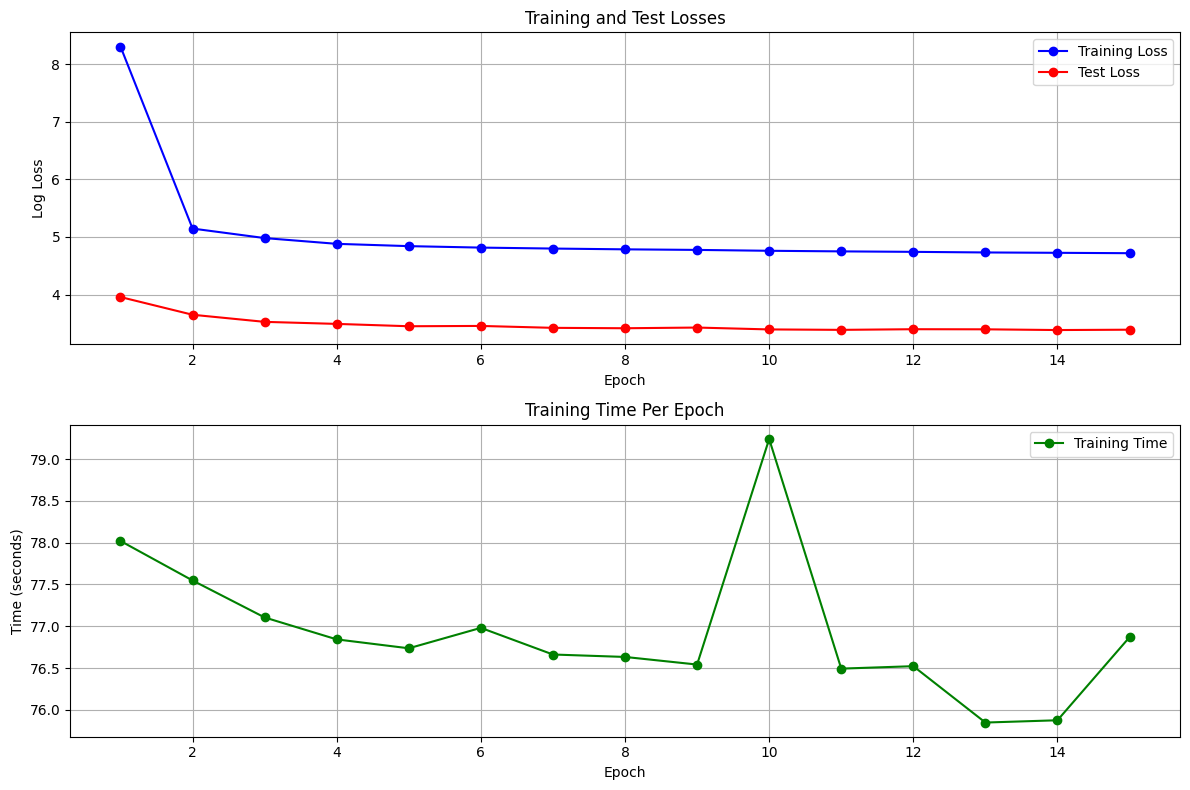

In [ ]:
# Set up epoch range
epochs = range(1, 16)

# Create figure with specific size
plt.figure(figsize=(12, 8))

# Plot training and test losses on a logarithmic scale
plt.subplot(2, 1, 1)
plt.plot(epochs, np.log(train_losses), label='Training Loss', marker='o', color='blue')
plt.plot(epochs, np.log(test_losses), label='Test Loss', marker='o', color='red')
plt.title('Logarithmic Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()
plt.grid()

# Plot training times per epoch
plt.subplot(2, 1, 2)
plt.plot(epochs, time_list, label='Training Time', marker='o', color='green')
plt.title('Training Time Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### **Analysis**

I believe that the inability to train deeper models prevented me from producing a piece of text that was actually legible, as it remained a mess of byte pair encoded tokens. However, there were some patterns in the text, such as "pilot" and "travel" appearing next to each other. Another likely issue was that at lower temperatures, the model would just repeat itself. This forced me to use higher temperatures, which failed to produce legible text. This is likely why the vanilla transformer, trained for just three epochs on a tinier subset of data, performed nearly as well as the larger model as it did not overfit.

"hectorrirs you sayie:m time too, baby t seasons i't let me th got done..im bet we would be too on falled alongly blue.y could all that man what it, (no"

In fact, the data might be overfit, indicated by the unnaturally low perplexity value of 1.04. I should consider checkpointing the model earlier to see if this leads to improved performance, rather than merely a higher loss.

**Conclusion**

This was an interesting deep dive into coding simple transformers for the first time and also experimenting and building upon existing literature. It has taught me that architecture is only one of the pillars of a good model; quality of data, hardware optimizations, and training methods are all essential to guaranteeing good performance. I would like to continue learning more about these.

[**Link to Colab Notebook**](https://colab.research.google.com/drive/10AKSUBJvSYvFJeXu2L8WGO6FOBIhr4YE?usp=sharing)

[**Model Weights**](https://github.com/MSaadAsad/Projects/blob/main/model_epoch_15.pt)

**Citations**

Ainslie, Joshua, et al. “GQA: Training Generalized Multi-Query Transformer Models from Multi-Head Checkpoints.” arXiv.Org, 23 Dec. 2023, doi.org/10.48550/arXiv.2305.13245.

Benistant, Francis. “Deep Dive into Deep Learning: Layers, RMSNorm, and Batch Normalization.” Medium, Medium, 14 Mar. 2024, 2020machinelearning.medium.com/deep-dive-into-deep-learning-layers-rmsnorm-and-batch-normalization-b2423552be9f.

Li, Jian, et al. “Multi-Head Attention with Disagreement Regularization.” arXiv.Org, 24 Oct. 2018, doi.org/10.48550/arXiv.1810.10183.

Pathak, Kaustubh. “Songs Lyrics.” Kaggle, 23 June 2020, www.kaggle.com/datasets/terminate9298/songs-lyrics.

Raposo, David, et al. “Mixture-of-Depths: Dynamically Allocating Compute in Transformer-Based Language Models.” arXiv.Org, 2 Apr. 2024, doi.org/10.48550/arXiv.2404.02258.

**AI Statement** GPT was used to research concepts like RMSE Norm and Byte Pair Encodings, and help it guiding me understand model training.